<a href="https://colab.research.google.com/github/Vaincookie/stock/blob/master/Chaotic_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Fin-Bert

In [ ]:
!pip install yfinance
!pip install transformers

In [ ]:
import yfinance
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import re
import yfinance as yf
import holidays
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing
from transformers import AutoTokenizer, AutoModelForSequenceClassification

def assign_GPU(Tokenizer_output):
    tokens_tensor = Tokenizer_output['input_ids'].to('cuda:0')
    token_type_ids = Tokenizer_output['token_type_ids'].to('cuda:0')
    attention_mask = Tokenizer_output['attention_mask'].to('cuda:0')

    output = {'input_ids' : tokens_tensor, 
            'token_type_ids' : token_type_ids, 
            'attention_mask' : attention_mask}

    return output

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to('cuda:0')

In [ ]:
import torch.nn.functional as F
def SentimentAnalyzer(doc):
    pt_batch = assign_GPU(tokenizer(doc,padding=True,truncation=True,max_length=512,return_tensors="pt"))
    outputs = model(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

In [ ]:
import pandas as pd
data1 = pd.read_csv('/content/drive/MyDrive/Fin-Chaotic-Bert/data/analyst_ratings_processed.csv', index_col=0)
data1.dropna(inplace = True)
data1.rename(columns={'stock':'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x : x.split()[0])
data2 = pd.read_csv('/content/drive/MyDrive/Fin-Chaotic-Bert/data/us_equities_news_dataset.csv', index_col=0)
data2.dropna(inplace = True)
data2.reset_index(drop=True, inplace=True)
data2.rename(columns={'release_date':'date'}, inplace=True)
data2.drop(inplace=True, columns=['category', 'content', 'provider', 'url', 'article_id'], axis=1)
data = pd.concat([data1, data2])
data.drop_duplicates(subset='title', keep='first', inplace=True)
data.drop(['ticker'],axis=1,inplace=True)
data

,title,date
0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05
1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03
2.0,71 Biggest Movers From Friday,2020-05-26
3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22
4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22
...,...,...
221500.0,Crude And Steel Still In Sync,2012-10-04
221501.0,Forget AT T This Is The Telecom Stock You Sho...,2012-05-30
221502.0,Wall Street Exposed Part 3 How Dividends C...,2012-07-16
221503.0,Weighing The Week Ahead It s All About Jobs,2012-09-02


In [ ]:
from torch.utils.data import Dataset, DataLoader
class NLPDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    def __getitem__(self,idx):
        return {'text': self.data.iloc[idx]['title'],
            'date': self.data.iloc[idx]['date']}

    def __len__(self):
        return len(self.data)

nlp_data = pd.DataFrame(columns=['date', 'pos', 'neg', 'neu'])
testdataset = NLPDataset(data)
testloader = DataLoader(testdataset,batch_size = 1)
for x in tqdm(testloader):
    output = SentimentAnalyzer(x['text'])
    pos=output[0][0]
    neg=output[0][1]
    neu=output[0][2]
    nlp_data = nlp_data.append([{'date':x['date'][0],
                'pos':pos,
                'neg':neg,
                'neu':neu,
                      }],ignore_index=True)

In [ ]:
nlp_data.to_csv('/content/drive/MyDrive/Fin-Chaotic-Bert/data/bert.csv',index=False)

## Merge Stock Close

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install yfinance
import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
nlp_data = pd.read_csv('/content/drive/MyDrive/Fin-Chaotic-Bert/data/bert.csv')

In [ ]:
# ONE_DAY = datetime.timedelta(days=1)
# HOLIDAYS_US = holidays.US()
def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day
def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg=sentimentArr[0]
    negAvg=sentimentArr[1]
    neuAvg=sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

In [ ]:
#(^GSPC => S&P500, ^IXIC => NasDaq, ^DJI => DowJones, AAPL => Apple Inc, AUDUSD=X => AUD/USD, USDJPY=X => USD/JPY, ^TNX => 10-Year Bond)'
tickerSymbol = '^GSPC'
# tickerSymbol = '^TNX'
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")
hist = hist.rename_axis('Date').reset_index()
hist["Date"] =hist["Date"].dt.strftime('%Y-%m-%d')
hist = hist.sort_values(['Date'], ascending=True)
hist['Log_return'] = hist['Close'] / hist['Close'].shift(1)-1
hist.dropna(inplace =True)

# nlp_data["Date"] = pd.to_datetime(nlp_data["Date"],format ="%Y-%m-%d")
# nlp_data["Date"] = nlp_data["Date"].astype(str)
# hist["Date"] = hist["Date"].astype(str)

In [ ]:
tmp1 = nlp_data.groupby(['Date'])['Pos'].agg(
    ['mean', 'median', 'skew', 'sum','max','min','std','var']).reset_index()
tmp1.columns = list(tmp1.columns[:1]) + ['Pos_mean', 'Pos_median', 'Pos_skew',\
                    'Pos_sum','Pos_max','Pos_min',\
                    'Pos_std','Pos_var']
tmp2 = nlp_data.groupby(['Date'])['Neg'].agg(
    ['mean', 'median', 'skew', 'sum','max','min','std','var']).reset_index()
tmp2.columns = list(tmp2.columns[:1]) + ['Neg_mean', 'Neg_median', 'Neg_skew',\
                    'Neg_sum','Neg_max','Neg_min',\
                    'Neg_std','Neg_var']

tmp3 = nlp_data.groupby(['Date'])['Neu'].agg(
    ['mean', 'median', 'skew', 'sum','max','min','std','var']).reset_index()
tmp3.columns = list(tmp3.columns[:1]) + ['Neu_mean', 'Neu_median', 'Neu_skew',\
                    'Neu_sum','Neu_max','Neu_min',\
                    'Neu_std','Neu_var']

In [ ]:
tmp = pd.merge(tmp1, tmp2, on='Date')
tmp = pd.merge(tmp, tmp3, on='Date')
tmp = tmp.fillna(0)
tmp

,Date,Pos_mean,Pos_median,Pos_skew,Pos_sum,Pos_max,Pos_min,Pos_std,Pos_var,Neg_mean,...,Neg_std,Neg_var,Neu_mean,Neu_median,Neu_skew,Neu_sum,Neu_max,Neu_min,Neu_std,Neu_var
0,2008-10-02,0.019304,0.019304,0.000000,0.019304,0.019304,0.019304,0.000000,0.000000,0.955048,...,0.000000,0.000000,0.025648,0.025648,0.000000,0.025648,0.025648,0.025648,0.000000,0.000000
1,2008-10-03,0.379272,0.283154,1.115674,1.517087,0.855977,0.094801,0.350002,0.122501,0.360851,...,0.364635,0.132959,0.259878,0.078992,1.983790,1.039511,0.830785,0.050741,0.381126,0.145257
2,2008-10-06,0.014690,0.014690,0.000000,0.029381,0.018411,0.010970,0.005262,0.000028,0.935810,...,0.038326,0.001469,0.049499,0.049499,0.000000,0.098999,0.072879,0.026119,0.033064,0.001093
3,2008-10-07,0.116676,0.116676,0.000000,0.233352,0.203010,0.030342,0.122095,0.014907,0.817594,...,0.118453,0.014031,0.065730,0.065730,0.000000,0.131460,0.068305,0.063155,0.003642,0.000013
4,2008-10-08,0.672860,0.672860,0.000000,0.672860,0.672860,0.672860,0.000000,0.000000,0.267953,...,0.000000,0.000000,0.059187,0.059187,0.000000,0.059187,0.059187,0.059187,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4206,2020-06-07,0.336019,0.098859,0.821460,4.704268,0.918993,0.019077,0.371516,0.138024,0.142055,...,0.274673,0.075445,0.521926,0.510801,-0.131926,7.306960,0.934483,0.038023,0.382696,0.146456
4207,2020-06-08,0.475728,0.487363,0.005041,164.126276,0.958012,0.007245,0.383551,0.147111,0.161534,...,0.282763,0.079955,0.362738,0.198548,0.606941,125.144441,0.949604,0.009753,0.347630,0.120846
4208,2020-06-09,0.295646,0.077432,0.890069,102.293444,0.957751,0.007363,0.349792,0.122354,0.325085,...,0.397245,0.157803,0.379269,0.245869,0.454492,131.227169,0.951119,0.011419,0.355894,0.126661
4209,2020-06-10,0.403002,0.221019,0.320052,132.184632,0.957267,0.006601,0.385694,0.148760,0.260581,...,0.374246,0.140060,0.336417,0.191429,0.692336,110.344733,0.951183,0.008481,0.345047,0.119057


In [ ]:
data = pd.merge(hist, tmp, how='right', on=['Date'])
data.dropna(inplace =True)
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log_return,Pos_mean,...,Neg_std,Neg_var,Neu_mean,Neu_median,Neu_skew,Neu_sum,Neu_max,Neu_min,Neu_std,Neu_var
0,2008-10-02,1160.640015,1160.640015,1111.430054,1114.280029,6.285640e+09,0.0,0.0,-0.040291,0.019304,...,0.000000,0.000000,0.025648,0.025648,0.000000,0.025648,0.025648,0.025648,0.000000,0.000000
1,2008-10-03,1115.160034,1153.819946,1098.140015,1099.229980,6.716120e+09,0.0,0.0,-0.013507,0.379272,...,0.364635,0.132959,0.259878,0.078992,1.983790,1.039511,0.830785,0.050741,0.381126,0.145257
2,2008-10-06,1097.560059,1097.560059,1007.969971,1056.890015,7.956020e+09,0.0,0.0,-0.038518,0.014690,...,0.038326,0.001469,0.049499,0.049499,0.000000,0.098999,0.072879,0.026119,0.033064,0.001093
3,2008-10-07,1057.599976,1072.910034,996.229980,996.229980,7.069210e+09,0.0,0.0,-0.057395,0.116676,...,0.118453,0.014031,0.065730,0.065730,0.000000,0.131460,0.068305,0.063155,0.003642,0.000013
4,2008-10-08,988.909973,1021.059998,970.969971,984.940002,8.716330e+09,0.0,0.0,-0.011333,0.672860,...,0.000000,0.000000,0.059187,0.059187,0.000000,0.059187,0.059187,0.059187,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,2020-06-05,3163.840088,3211.719971,3163.840088,3193.929932,8.639300e+09,0.0,0.0,0.026212,0.492516,...,0.302924,0.091763,0.324118,0.163276,0.770025,94.966436,0.942515,0.013323,0.331248,0.109725
4207,2020-06-08,3199.919922,3233.129883,3196.000000,3232.389893,8.498300e+09,0.0,0.0,0.012042,0.475728,...,0.282763,0.079955,0.362738,0.198548,0.606941,125.144441,0.949604,0.009753,0.347630,0.120846
4208,2020-06-09,3213.320068,3222.709961,3193.110107,3207.179932,6.410930e+09,0.0,0.0,-0.007799,0.295646,...,0.397245,0.157803,0.379269,0.245869,0.454492,131.227169,0.951119,0.011419,0.355894,0.126661
4209,2020-06-10,3213.419922,3223.270020,3181.489990,3190.139893,6.598870e+09,0.0,0.0,-0.005313,0.403002,...,0.374246,0.140060,0.336417,0.191429,0.692336,110.344733,0.951183,0.008481,0.345047,0.119057


In [ ]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Log_return', 'Pos_mean', 'Pos_median', 'Pos_skew',
       'Pos_sum', 'Pos_max', 'Pos_min', 'Pos_std', 'Pos_var', 'Neg_mean',
       'Neg_median', 'Neg_skew', 'Neg_sum', 'Neg_max', 'Neg_min', 'Neg_std',
       'Neg_var', 'Neu_mean', 'Neu_median', 'Neu_skew', 'Neu_sum', 'Neu_max',
       'Neu_min', 'Neu_std', 'Neu_var'],
      dtype='object')

# Dataset

In [ ]:
Target = 1
data = data.sort_values(['Date'], ascending=True)
#相同时间记得mean
data.drop(['Date'],axis=1,inplace=True)
if Target == 0:
    data =data[['Log_return','Close', 'Open', 'High', 'Low', 'Volume', 'Dividends',
        'Stock Splits', 'Pos_mean', 'Pos_median', 'Pos_skew', 'Pos_sum',
        'Pos_max', 'Pos_min', 'Pos_std', 'Pos_var', 'Neg_mean', 'Neg_median',
        'Neg_skew', 'Neg_sum', 'Neg_max', 'Neg_min', 'Neg_std', 'Neg_var',
        'Neu_mean', 'Neu_median', 'Neu_skew', 'Neu_sum', 'Neu_max', 'Neu_min',
        'Neu_std', 'Neu_var']]
elif Target == 7:
    data =data[['Close','Log_return', 'Open', 'High', 'Low', 'Volume', 'Dividends',
        'Stock Splits', 'Pos_mean', 'Neg_mean', 'Neu_mean']]
else:
    data =data[['Close','Log_return', 'Open', 'High', 'Low', 'Volume', 'Dividends',
        'Stock Splits', 'Pos_mean', 'Pos_median', 'Pos_skew', 'Pos_sum',
        'Pos_max', 'Pos_min', 'Pos_std', 'Pos_var', 'Neg_mean', 'Neg_median',
        'Neg_skew', 'Neg_sum', 'Neg_max', 'Neg_min', 'Neg_std', 'Neg_var',
        'Neu_mean', 'Neu_median', 'Neu_skew', 'Neu_sum', 'Neu_max', 'Neu_min',
        'Neu_std', 'Neu_var']]
data

,Close,Log_return,Open,High,Low,Volume,Dividends,Stock Splits,Pos_mean,Pos_median,...,Neg_std,Neg_var,Neu_mean,Neu_median,Neu_skew,Neu_sum,Neu_max,Neu_min,Neu_std,Neu_var
0,1114.280029,-0.040291,1160.640015,1160.640015,1111.430054,6.285640e+09,0.0,0.0,0.019304,0.019304,...,0.000000,0.000000,0.025648,0.025648,0.000000,0.025648,0.025648,0.025648,0.000000,0.000000
1,1099.229980,-0.013507,1115.160034,1153.819946,1098.140015,6.716120e+09,0.0,0.0,0.379272,0.283154,...,0.364635,0.132959,0.259878,0.078992,1.983790,1.039511,0.830785,0.050741,0.381126,0.145257
2,1056.890015,-0.038518,1097.560059,1097.560059,1007.969971,7.956020e+09,0.0,0.0,0.014690,0.014690,...,0.038326,0.001469,0.049499,0.049499,0.000000,0.098999,0.072879,0.026119,0.033064,0.001093
3,996.229980,-0.057395,1057.599976,1072.910034,996.229980,7.069210e+09,0.0,0.0,0.116676,0.116676,...,0.118453,0.014031,0.065730,0.065730,0.000000,0.131460,0.068305,0.063155,0.003642,0.000013
4,984.940002,-0.011333,988.909973,1021.059998,970.969971,8.716330e+09,0.0,0.0,0.672860,0.672860,...,0.000000,0.000000,0.059187,0.059187,0.000000,0.059187,0.059187,0.059187,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,3193.929932,0.026212,3163.840088,3211.719971,3163.840088,8.639300e+09,0.0,0.0,0.492516,0.566365,...,0.302924,0.091763,0.324118,0.163276,0.770025,94.966436,0.942515,0.013323,0.331248,0.109725
4207,3232.389893,0.012042,3199.919922,3233.129883,3196.000000,8.498300e+09,0.0,0.0,0.475728,0.487363,...,0.282763,0.079955,0.362738,0.198548,0.606941,125.144441,0.949604,0.009753,0.347630,0.120846
4208,3207.179932,-0.007799,3213.320068,3222.709961,3193.110107,6.410930e+09,0.0,0.0,0.295646,0.077432,...,0.397245,0.157803,0.379269,0.245869,0.454492,131.227169,0.951119,0.011419,0.355894,0.126661
4209,3190.139893,-0.005313,3213.419922,3223.270020,3181.489990,6.598870e+09,0.0,0.0,0.403002,0.221019,...,0.374246,0.140060,0.336417,0.191429,0.692336,110.344733,0.951183,0.008481,0.345047,0.119057


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import matplotlib.pyplot as plt
from torch.autograd import Variable
import csv

In [ ]:
# Separate data sets (80% - 20%)
train_proportion = 0.8
test_proportion = 0.2
train_data = data[:int(data.shape[0] * train_proportion)]
test_data = data[int(data.shape[0] * train_proportion):]

In [ ]:
scaler = MinMaxScaler()
train_data = train_data.values.astype('float32')
test_data = test_data.values.astype('float32')
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

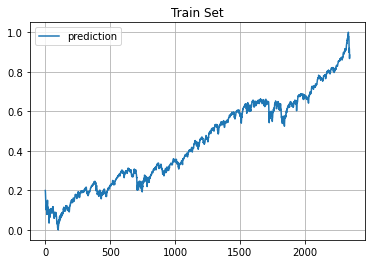

In [ ]:
import matplotlib.pyplot as plt
# final_result = np.array(result)
# final_true = np.array(true)
plt.plot(train_data[:,0], label='prediction')
# plt.plot(final_true, label='true')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.title('Train Set')
plt.show()

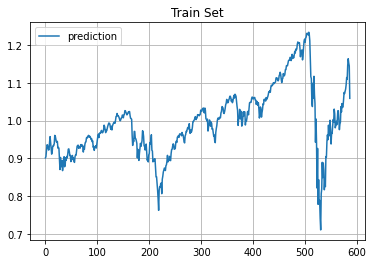

In [ ]:
import matplotlib.pyplot as plt
# final_result = np.array(result)
# final_true = np.array(true)
plt.plot(test_data[:,0], label='prediction')
# plt.plot(final_true, label='true')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.title('Train Set')
plt.show()

In [ ]:
# Create data set matrix
def create_dataset(dataset, steps):
    data_x, data_y ,data_z= [], [], []
    for i in range(len(dataset) - steps):
        data_x.append(dataset[i: i + steps,0:8])
        data_z.append(dataset[i: i + steps,8:])
        data_y.append(dataset[i + steps, 0])  # the first item
    return np.array(data_x),np.array(data_z), np.array(data_y)

In [ ]:
# Reconstructing the data set
time_steps = 15
trainX,trainZ,trainY = create_dataset(train_data, time_steps)
testX,testZ, testY = create_dataset(test_data, time_steps)

In [ ]:
# Re-type
trainX = torch.from_numpy(trainX).to(torch.float32)
trainZ = torch.from_numpy(trainZ).to(torch.float32)
trainY = torch.from_numpy(trainY).to(torch.float32)
testX = torch.from_numpy(testX).to(torch.float32)
testZ = torch.from_numpy(testZ).to(torch.float32)
testY = torch.from_numpy(testY).to(torch.float32)

# Model

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pandas as pd
from tqdm import trange

# Create the class for the Lee-Oscillator.
class LeeOscillator():
    '''
        The Lee-Oscillator based activation function.\n
        Params:\n
            - a (list), The parameters list for Lee-Oscillator of Tanh.\n
            - b (list), The parameters list for Lee-Oscillator of Sigmoid.\n
            - K (integer), The K coefficient of the Lee-Oscillator.\n
            - N (integer), The number of iterations of the Lee-Oscillator.\n
    '''
    # Create the constructor.
    def __init__(self, a = [-0.2, 0.45, 0.6, 1, 0, -0.55, 0.55, 0], b = [0.6, 0.6, -0.5, 0.5, -0.6, -0.6, -0.5, 0.5], K = 50, N = 100):
        # Get the parameters for the Lee-Oscillator.
        self.a = a
        self.b = b
        self.K = K
        self.N = N
        # Draw the bifraction diagram of the Lee-Oscillator.
        if (not os.path.exists('./LeeOscillator-Tanh.csv')) or (not os.path.exists('./LeeOscillator-Sigmoid.csv')):
            # Compute the Lee-Oscillator.
            self.TanhCompute(a1 = a[0], a2 = a[1], a3 = a[2], a4 = a[3], b1 = a[4], b2 = a[5], b3 = a[6], b4 = a[7], K = K, N = N)
            self.SigmoidCompute(a1 = a[0], a2 = a[1], a3 = a[2], a4 = a[3], b1 = a[4], b2 = a[5], b3 = a[6], b4 = a[7], K = K, N = N)

    # Create the function to apply the Lee-Oscillator of tanh activation function.
    def Tanh(self, x):
        # Get the random number.
        N = np.random.randint(1, self.N + 1)
        u = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
        v = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
        z = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
        w = 0
        u[0] = u[0] + 0.2
        z[0] = z[0] + 0.2
        for t in range(0, N - 1):
            u[t + 1] = torch.tanh(self.a[0] * u[t] - self.a[1] * v[t] + self.a[2] * z[t] + self.a[3] * x)
            v[t + 1] = torch.tanh(self.a[6] * z[t] - self.a[4] * u[t] - self.a[5] * v[t] + self.a[7] * x)
            w = torch.tanh(x)
            z[t + 1] = (v[t + 1] - u[t + 1]) * torch.exp(-self.K * torch.pow(x, 2)) + w
        return Variable(z[-1],requires_grad=True)
        # # Form the output tensor.
        # output = torch.zeros(x.shape).to(x.device)
        # # Get each value of the output.
        # for i in range(0, output.shape[0]):
        #     for j in range(0, output.shape[1]):
        #         if x[i][j] + 1 <= 0:
        #             output[i][j] = -0.9999
        #         elif x[i][j] - 1 >= 0:
        #             output[i][j] = 0.9999
        #         else:
        #             row = math.floor((x[i][j] + 1) / 0.002)
        #             col = random.randint(0, 99)
        #             output[i][j] = self.tanh[row][col]
        # # Return the output.
        # return Variable(output, requires_grad = True)

    # Create the function to apply the Lee-Oscillator of sigmoid activation function.
    def Sigmoid(self, x):
        # Get the random number.
        N = np.random.randint(1, self.N + 1)
        u = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
        v = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
        z = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
        w = 0
        u[0] = u[0] + 0.2
        z[0] = z[0] + 0.2
        for t in range(0, N - 1):
            u[t + 1] = torch.sigmoid(self.b[0] * u[t] - self.b[1] * v[t] + self.b[2] * z[t] + self.b[3] * x)
            v[t + 1] = torch.sigmoid(self.b[6] * z[t] - self.b[4] * u[t] - self.b[5] * v[t] + self.b[7] * x)
            w = torch.sigmoid(x)
            z[t + 1] = (v[t + 1] - u[t + 1]) * torch.exp(-self.K * torch.pow(x, 2)) + w
        return Variable(z[-1],requires_grad=True)
        # # Form the output tensor.
        # output = torch.zeros(x.shape).to(x.device)
        # # Get each value of the output.
        # for i in range(0, output.shape[0]):
        #     for j in range(0, output.shape[1]):
        #         if x[i][j] + 1 <= 0:
        #             output[i][j] = 0.0001
        #         elif x[i][j] - 1 >= 0:
        #             output[i][j] = 0.9999
        #         else:
        #             row = math.floor((x[i][j] + 1) / 0.002)
        #             col = random.randint(0, 99)
        #             output[i][j] = self.sigmoid[row][col]
        # # Return the output.
        # return Variable(output, requires_grad = True)

    # Create the function to compute the Lee-Oscillator of tanh activation function.
    def TanhCompute(self, a1, a2, a3, a4, b1, b2, b3, b4, K, N):
        # Create the array to store and compute the value of the Lee-Oscillator.
        u = torch.zeros([N])
        v = torch.zeros([N])
        z = torch.zeros([N])
        w = 0
        u[0] = 0.2
        z[0] = 0.2
        Lee = np.zeros([1000, N])
        xAix = np.zeros([1000 * N])
        j = 0
        x = 0
        for i in np.arange(-1, 1, 0.002):
            for t in range(0, N - 1):
                u[t + 1] = torch.tanh(a1 * u[t] - a2 * v[t] + a3 * z[t] + a4 * i)
                v[t + 1] = torch.tanh(b3 * z[t] - b1 * u[t] - b2 * v[t] + b4 * i)
                w = torch.tanh(torch.Tensor([i]))
                z[t + 1] = (v[t + 1] - u[t + 1]) * np.exp(-K * np.power(i, 2)) + w
                # Store the Lee-Oscillator.
                xAix[j] = i
                j = j + 1
                Lee[x, t] = z[t + 1]
            Lee[x, t + 1] = z[t + 1]
            x = x + 1
    # Create the function to compute the Lee-Oscillator of sigmoid activation function.
    def SigmoidCompute(self, a1, a2, a3, a4, b1, b2, b3, b4, K, N):
        # Create the array to store and compute the value of the Lee-Oscillator.
        u = torch.zeros([N])
        v = torch.zeros([N])
        z = torch.zeros([N])
        w = 0
        u[0] = 0.2
        z[0] = 0.2
        Lee = np.zeros([1000, N])
        xAix = np.zeros([1000 * N])
        j = 0
        x = 0
        for i in np.arange(-1, 1, 0.002):
            for t in range(0, N - 1):
                u[t + 1] = torch.tanh(a1 * u[t] - a2 * v[t] + a3 * z[t] + a4 * i)
                v[t + 1] = torch.tanh(b3 * z[t] - b1 * u[t] - b2 * v[t] + b4 * i)
                w = torch.tanh(torch.Tensor([i]))
                z[t + 1] = (v[t + 1] - u[t + 1]) * np.exp(-K * np.power(i, 2)) + w
                # Store the Lee-Oscillator.
                xAix[j] = i
                j = j + 1
                Lee[x, t] = z[t + 1] / 2 + 0.5
            Lee[x, t + 1] = z[t + 1] / 2 + 0.5
            x = x + 1


In [ ]:
# import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear


def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()


def gen_trg_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1

    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )

    return mask


class TimeSeriesForcasting(nn.Module):
    def __init__(
        self,
        n_encoder_inputs,
        n_decoder_inputs,
        channels=1024,
        dropout=0.2,
        lr=1e-4,
    ):
        super().__init__()


        self.lr = lr
        self.dropout = dropout

        self.input_pos_embedding = torch.nn.Embedding(512, embedding_dim=channels)
        self.target_pos_embedding = torch.nn.Embedding(512, embedding_dim=channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=1 * channels,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=1 * channels,
        )

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=1)

        self.input_projection = Linear(n_encoder_inputs, channels)
        self.output_projection = Linear(n_decoder_inputs, channels)

        self.linear = Linear(channels, 1)

        self.ensemble =  nn.Sequential(
                nn.Linear(2, 32),
                nn.Linear(32, 1),
            )

        self.do = nn.Dropout(p=self.dropout)

        #self.predict = Linear(15, 1)

        self.projection_size = 256
        self.predict = nn.Sequential(
                nn.Linear(15, self.projection_size),
                #nn.BatchNorm1d(self.projection_size),
                nn.ReLU(inplace=True),
                #nn.Linear(self.projection_size, self.projection_size),
                #nn.BatchNorm1d(self.projection_size),
                nn.Linear(self.projection_size, 1),
            )
        self.Lee = LeeOscillator(a = [-0.2, 0.45, 0.6, 1, 0, -0.55, 0.55, 0], b = [0.6, 0.6, -0.5, 0.5, -0.6, -0.6, -0.5, 0.5], K = 50, N = 10)
        self.lsmt_hidden = 512
        #self.lstm_price = nn.LSTM(n_encoder_inputs, self.lsmt_hidden, batch_first=False)
        self.lstm_price =nn.LSTM(input_size=n_encoder_inputs,
                               hidden_size=1024,
                               num_layers=1,
                               batch_first=False,
                               bidirectional=False)
        #nn.LSTM(input_size=self.embedding_dim,
                            #    hidden_size=num_hiddens,
                            #    num_layers=num_layers,
                            #    batch_first=False,
                            #    bidirectional=True)
        #
        #self.lstm_nlp = nn.LSTM(n_decoder_inputs, self.lsmt_hidden, batch_first=False)
        self.lstm_nlp = nn.LSTM(input_size=n_decoder_inputs,
                               hidden_size=1024,
                               num_layers=1,
                               batch_first=False,
                               bidirectional=False)
    def encode_src(self, src):

        # torch.Size([batch, seq, input])
        src = src.permute(1, 0, 2)
        
        # torch.Size([seq, batch, feature])
        src_start,_ = self.lstm_price(src)
        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        # print('pos',pos_encoder.shape)
        #pos torch.Size([batch, seq])

        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)
        #pos2 torch.Size([seq, batch, chanall])

        src = src_start + pos_encoder

        src = self.encoder(src_start) + src_start

        return src

    def decode_trg(self, trg, memory):

        trg = trg.permute(1, 0, 2)

        trg_start,_ = self.lstm_nlp(trg)

        out_sequence_len, batch_size = trg_start.size(0), trg_start.size(1)

        pos_decoder = (
            torch.arange(0, out_sequence_len, device=trg.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)

        trg = pos_decoder + trg_start

        trg_mask = gen_trg_mask(out_sequence_len, trg.device)

        out = self.decoder(tgt=trg, memory=memory, tgt_mask=trg_mask) + trg_start

        out = out.permute(1, 0, 2)

        out = self.linear(out)

        return out

    def forward(self, x):
        trg, src = x
        
        src = self.encode_src(src)

        out = self.decode_trg(trg=trg, memory=src)

        out = out.squeeze(2)
        
        raw_prediction = self.predict(out)

        chaotic_prediction = self.Lee.Sigmoid(raw_prediction)

        # print('prediction.shape',raw_prediction.shape)

        # print('chaotic_prediction.shape',chaotic_prediction.shape)

        ensemble = self.ensemble(torch.cat([raw_prediction,chaotic_prediction],1))

        # print('ensemble.shape',ensemble.shape)
        ensemble = ensemble.squeeze(1)

        return ensemble


In [ ]:

class BiLSTM_Attention(nn.Module):
    def __init__(self,  n_encoder_inputs, n_decoder_inputs, num_hiddens, num_layers):
        super(BiLSTM_Attention, self).__init__()
        # embedding之后的shape: torch.Size([200, 8, 300])
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # self.word_embeddings = self.word_embeddings.from_pretrained(
        #     vectors, freeze=False)
        self.embedding_dim = 1024

        self.feature_embeddings =nn.Linear(n_encoder_inputs,self.embedding_dim)
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=self.embedding_dim,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               batch_first=False,
                               bidirectional=True)
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.w_omega = nn.Parameter(torch.Tensor(
            num_hiddens * 2, num_hiddens * 2))
        self.u_omega = nn.Parameter(torch.Tensor(num_hiddens * 2, 1))
        self.decoder = nn.Linear(2*num_hiddens, 1)

        nn.init.uniform_(self.w_omega, -0.1, 0.1)
        nn.init.uniform_(self.u_omega, -0.1, 0.1)

        
        

    def forward(self, inputs):

        src, trg = inputs
        # torch.Size([batch, seq, input])
        src_start = src.permute(1, 0, 2)
        # torch.Size([seq, batch, feature])

        # inputs的形状是(seq_len,batch_size, feature)
        embeddings = self.feature_embeddings(src_start)
        # 提取特征，输出形状为(seq_len,batch_size,embedding_dim)

        # rnn.LSTM只返回最后一层的隐藏层在各时间步的隐藏状态。
        outputs, _ = self.encoder(embeddings)  # output, (h, c)
        # outputs形状是(seq_len,batch_size, 2 * num_hiddens)
        x = outputs.permute(1, 0, 2)
        # x形状是(batch_size, seq_len, 2 * num_hiddens)
        
        # Attention过程
        u = torch.tanh(torch.matmul(x, self.w_omega))
        # u形状是(batch_size, seq_len, 2 * num_hiddens)
        att = torch.matmul(u, self.u_omega)
        # att形状是(batch_size, seq_len, 1)
        att_score = F.softmax(att, dim=1)
        # att_score形状仍为(batch_size, seq_len, 1)
        scored_x = x * att_score
        # scored_x形状是(batch_size, seq_len, 2 * num_hiddens)
        # Attention过程结束

        
        feat = torch.sum(scored_x, dim=1) #加权求和
       # feat形状是(batch_size, 2 * num_hiddens)
        outs = self.decoder(feat)
        outs = outs.squeeze(1)
       # out形状是(batch_size, 2)
        return outs

In [ ]:
import torch.nn.functional  as F
class LSTM(nn.Module):
    def __init__(self,  n_encoder_inputs, n_decoder_inputs, num_hiddens, num_layers):
        super(BiLSTM_Attention, self).__init__()
        # embedding之后的shape: torch.Size([200, 8, 300])
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # self.word_embeddings = self.word_embeddings.from_pretrained(
        #     vectors, freeze=False)
        self.embedding_dim = 1024

        self.feature_embeddings =nn.Linear(n_encoder_inputs,self.embedding_dim)
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=self.embedding_dim,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               batch_first=False,
                               bidirectional=True)
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.w_omega = nn.Parameter(torch.Tensor(
            num_hiddens * 2, num_hiddens * 2))
        self.u_omega = nn.Parameter(torch.Tensor(num_hiddens * 2, 1))
        self.decoder = nn.Linear(2*num_hiddens, 1)

        nn.init.uniform_(self.w_omega, -0.1, 0.1)
        nn.init.uniform_(self.u_omega, -0.1, 0.1)

        
        

    def forward(self, inputs):

        src, trg = inputs
        # torch.Size([batch, seq, input])
        src_start = src.permute(1, 0, 2)
        # torch.Size([seq, batch, feature])

        # inputs的形状是(seq_len,batch_size, feature)
        embeddings = self.feature_embeddings(src_start)
        # 提取特征，输出形状为(seq_len,batch_size,embedding_dim)

        # rnn.LSTM只返回最后一层的隐藏层在各时间步的隐藏状态。
        outputs, _ = self.encoder(embeddings)  # output, (h, c)
        # outputs形状是(seq_len,batch_size, 2 * num_hiddens)
        x = outputs.permute(1, 0, 2)
        # x形状是(batch_size, seq_len, 2 * num_hiddens)
        
        # Attention过程
        u = torch.tanh(torch.matmul(x, self.w_omega))
        # u形状是(batch_size, seq_len, 2 * num_hiddens)
        att = torch.matmul(u, self.u_omega)
        # att形状是(batch_size, seq_len, 1)
        att_score = F.softmax(att, dim=1)
        # att_score形状仍为(batch_size, seq_len, 1)
        scored_x = x * att_score
        # scored_x形状是(batch_size, seq_len, 2 * num_hiddens)
        # Attention过程结束

        
        feat = torch.sum(scored_x, dim=1) #加权求和
       # feat形状是(batch_size, 2 * num_hiddens)
        outs = self.decoder(feat)
        outs = outs.squeeze(1)
       # out形状是(batch_size, 2)
        return outs

# Test Model

In [ ]:
# import pytorch_lightning as pl
import torch
import torch.nn as nn
from torch.nn import Linear


def smape_loss(y_pred, target):
    loss = 2 * (y_pred - target).abs() / (y_pred.abs() + target.abs() + 1e-8)
    return loss.mean()


def gen_trg_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1

    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )

    return mask


class TimeSeriesForcasting(nn.Module):
    def __init__(
        self,
        n_encoder_inputs,
        n_decoder_inputs,
        channels=1024,
        dropout=0.1,
        lr=1e-4,
        a1 = 1,
        a2 = 1,
        a3 = 1,
        a4 = 1,
        b1 = 1,
        b2 = 1,
        b3 = 1,
        b4 = 1,
        parm_K=None,
        parm_N=None
    ):
        super().__init__()


        self.lr = lr
        self.dropout = dropout

        self.input_pos_embedding = torch.nn.Embedding(512, embedding_dim=channels)
        self.target_pos_embedding = torch.nn.Embedding(512, embedding_dim=channels)

        encoder_layer1 = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=8,
            dropout=self.dropout,
            dim_feedforward=1 * channels,
        )

        encoder_layer2 = nn.TransformerEncoderLayer(
            d_model=channels,
            nhead=4,
            dropout=self.dropout,
            dim_feedforward=1 * channels,
        )


        self.encoder_price = torch.nn.TransformerEncoder(encoder_layer1, num_layers=3)
        self.encoder_nlp = torch.nn.TransformerEncoder(encoder_layer2, num_layers=1)

        self.input_projection = Linear(n_encoder_inputs, channels)
        self.output_projection = Linear(n_decoder_inputs, channels)

        self.linear = Linear(channels, 1)
        self.linear2 = Linear(channels, 1)

        self.ensemble =  nn.Sequential(
                nn.Linear(3, 32),
                nn.Linear(32, 1),
            )

        self.do = nn.Dropout(p=self.dropout)


        self.projection_size = 256
        self.predict = nn.Sequential(
                nn.Linear(1024*2, self.projection_size),
                #nn.BatchNorm1d(self.projection_size),
                nn.ReLU(inplace=True),
                #nn.Linear(self.projection_size, self.projection_size),
                #nn.BatchNorm1d(self.projection_size),
                nn.Linear(self.projection_size, 1),
            )
        self.predict2 = nn.Sequential(
                nn.Linear(15, self.projection_size),
                #nn.BatchNorm1d(self.projection_size),
                nn.ReLU(inplace=True),
                #nn.Linear(self.projection_size, self.projection_size),
                #nn.BatchNorm1d(self.projection_size),
                nn.Linear(self.projection_size, 1),
            )
        self.Lee = LeeOscillator(a = [a1, a2, a3, a4, b1, b2, b3, b4], b = [0.6, 0.6, -0.5, 0.5, -0.6, -0.6, -0.5, 0.5], K = parm_K, N = parm_N)
        self.lsmt_hidden = 512
        #self.lstm_price = nn.LSTM(n_encoder_inputs, self.lsmt_hidden, batch_first=False)
        self.lstm_price =nn.LSTM(input_size=n_encoder_inputs,
                               hidden_size=1024,
                               num_layers=1,
                               batch_first=False,
                               bidirectional=False)

        self.lstm_nlp = nn.LSTM(input_size=n_decoder_inputs,
                               hidden_size=1024,
                               num_layers=1,
                               batch_first=False,
                               bidirectional=False)
        
        self.bilstm_price =nn.LSTM(input_size=n_encoder_inputs,
                               hidden_size=1024,
                               num_layers=1,
                               batch_first=False,
                               bidirectional=True)
        

        self.linear_out = nn.Linear(15, 1)
    def encode_price(self, src):

        # torch.Size([batch, seq, input])
        src = src.permute(1, 0, 2)
        
        # torch.Size([seq, batch, feature])
        src_start,_ = self.lstm_price(src)
        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (
            torch.arange(0, in_sequence_len, device=src.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        # print('pos',pos_encoder.shape)
        #pos torch.Size([batch, seq])

        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)
        #pos2 torch.Size([seq, batch, chanall])

        src = src_start + pos_encoder

        src = self.encoder_price(src_start) + pos_encoder


        src = src.permute(1, 0, 2)

        src = self.linear2(src)

        return src

    def encode_nlp(self, trg):

        trg = trg.permute(1, 0, 2)

        trg_start,_ = self.lstm_nlp(trg)

        out_sequence_len, batch_size = trg_start.size(0), trg_start.size(1)

        pos_encoder = (
            torch.arange(0, out_sequence_len, device=trg.device)
            .unsqueeze(0)
            .repeat(batch_size, 1)
        )
        pos_encoder = self.target_pos_embedding(pos_encoder).permute(1, 0, 2)

        trg = pos_encoder + trg_start

        out = self.encoder_nlp(trg_start) + pos_encoder

        out = out.permute(1, 0, 2)

        out = self.linear(out)

        return out

    def forward(self, x):
        stock,nlp = x
        
        #stock = self.encode_price(stock)
        stock = stock.permute(1, 0, 2)
        #stock.shape torch.Size([15, 1024, 8])

        stock,_ = self.bilstm_price(stock)
        #lstock.shape torch.Size([15, 1024, 1024]) 
        raw_prediction_stock = self.predict(stock)
         
        #raw_prediction_stock.shape torch.Size([15, 1024, 1]) 
        raw_prediction_stock = raw_prediction_stock.squeeze(2)
        raw_prediction_stock = raw_prediction_stock.permute(1, 0)
        raw_prediction_stock = self.linear_out(raw_prediction_stock)
        # raw_prediction_stock = raw_prediction_stock.permute(1, 0, 2)
        nlp = self.encode_nlp(nlp)  
        nlp = nlp.squeeze(2)

        # nlp.shape torch.Size([16, 15, 1])
        # stock.shape torch.Size([15, 16, 1024])
        # nlp.shape torch.Size([16, 15])
        # stock.shape torch.Size([15, 16, 1024])
        
        
        raw_prediction_nlp = self.predict2(nlp)

        
        # raw_prediction_stock.shape torch.Size([15, 1024])
        # raw_prediction_nlp.shape torch.Size([15, 1024])

        chaotic_prediction = self.Lee.Sigmoid(raw_prediction_stock)

        # chaotic_prediction.shape torch.Size([15, 1024])
        # raw_prediction_stock.shape torch.Size([15, 1024])
        # raw_prediction_nlp.shape torch.Size([1024, 1])


        ensemble = self.ensemble(torch.cat([raw_prediction_stock,chaotic_prediction,raw_prediction_nlp],1))

        # print('ensemble.shape',ensemble.shape)
        ensemble = ensemble.squeeze(1)

        return ensemble


# Chaotic Testing

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 31.4 MB/s 
     |████████████████████████████████| 209 kB 76.0 MB/s 
     |████████████████████████████████| 81 kB 12.1 MB/s 
     |████████████████████████████████| 78 kB 9.7 MB/s 
     |████████████████████████████████| 50 kB 8.5 MB/s 
     |████████████████████████████████| 147 kB 80.0 MB/s 
     |████████████████████████████████| 112 kB 70.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7299d7369411ae24b0169e6c6437c6308130946d6fad22da6a5b51fcbd14e6ad
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip


In [ ]:
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader
from tqdm import trange
import copy
import optuna

DEBUG = False
lr = 1e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainX = trainX.to(device)
trainY = trainY.to(device)
trainZ = trainZ.to(device)
testX = testX.to(device)
testZ = testZ.to(device)
testY = testY.to(device)
#Define loss
loss_function = nn.MSELoss()
MODEL_CHOOSEN = 1
#Create the model
def objective(trial):
    if MODEL_CHOOSEN == 1:
        model = TimeSeriesForcasting(n_encoder_inputs=8,n_decoder_inputs=24, 
        a1 = trial.suggest_float("a1", -1,1 ),
        a2 = trial.suggest_float("a2", -1,1 ),
        a3 = trial.suggest_float("a3", -1,1 ),
        a4 = trial.suggest_float("a4", -1,1 ),
        b1 = trial.suggest_float("b1", -1,1 ),
        b2 = trial.suggest_float("b2", -1,1 ),
        b3 = trial.suggest_float("b3", -1,1 ),
        b4 = trial.suggest_float("b4", -1,1 ),
        parm_K=trial.suggest_int("K",5, 500, step=5),
        parm_N=trial.suggest_int("N",5, 100, step=5))

    elif MODEL_CHOOSEN == 2:
        model = BiLSTM_Attention(n_encoder_inputs=8, n_decoder_inputs=3, num_hiddens=1024, num_layers=4)
    else:
        model = TimeSeriesForcasting(n_encoder_inputs=8,n_decoder_inputs=8)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    if DEBUG == True:
        dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainZ).float()),
                                    shuffle=False, batch_size=16)
        dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testZ).float()),
                                    shuffle=False, batch_size=16)
    else:
        dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainZ).float()),
                                    shuffle=False, batch_size=1024)
        dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testZ).float()),
                                    shuffle=False, batch_size=1024)

    best_model = None
    best_loss = 100
    scheduler_mode = True
    list_loss = []
    # Start train
    begin = time.time()
    epochs = 200
    model_select = 0
    list_x = []
    list_y = []

    for epoch in trange(epochs):
        batch_loss = 0
        iter = 0
        for batch_idx,(data_dl, target_dl, train_decoder_dl) in enumerate(dl_train):
            data_dl, target_dl, train_decoder_dl = data_dl.to(device) , target_dl.to(device), train_decoder_dl.to(device)
            init_states = None
            optimizer.zero_grad()
            if MODEL_CHOOSEN == 1:
                output = model((data_dl,train_decoder_dl))
            elif MODEL_CHOOSEN == 2:
                output = model((data_dl,train_decoder_dl))
            else:
                output = model((data_dl,data_dl))
            loss = loss_function(output, target_dl)
            
            loss.backward()
            optimizer.step()

            valid_dl = target_dl.cpu()
            valid_dl = valid_dl.data.numpy()
            pre_output = output.cpu()
            pre_output = pre_output.data.numpy()
            batch_loss += loss.item()
            iter +=1
        epoch_loss = batch_loss/iter
        if (epoch + 1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}, learning rate:{}'.format(epoch + 1, epoch_loss, scheduler.get_last_lr()))
        
        if scheduler_mode == True:
            scheduler.step()
        if epoch_loss < best_loss:
            best_model = model
            best_loss =epoch_loss


        list_x.append(epoch)
        list_y.append(epoch_loss)

    time_elapsed = time.time() - begin
    print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    model = best_model
    return best_loss



In [ ]:
study = optuna.create_study(direction="minimize", study_name="Chaotic Learning")
func = lambda trial: objective(trial)
study.optimize(func, n_trials=300)

[I 2022-12-13 14:03:15,506] A new study created in memory with name: Chaotic Learning
<ipython-input-27-825838f33f19>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainZ).float()),
<ipython-input-27-825838f33f19>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testZ).float()),
 50%|█████     | 100/200 [02:09<02:10,  1.31s/it]

Epoch: 100, Loss:0.00024, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 14:07:52,565] Trial 0 finished with value: 0.00022708304459229112 and parameters: {'a1': 0.4965192222553372, 'a2': -0.5021800859861985, 'a3': -0.024846032508999416, 'a4': -0.5433267377980497, 'b1': 0.6281759570433221, 'b2': -0.39157991047033414, 'b3': -0.310442627652608, 'b4': -0.536827070750727, 'K': 475, 'N': 50}. Best is trial 0 with value: 0.00022708304459229112.


Epoch: 200, Loss:0.00023, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:13<02:12,  1.33s/it]

Epoch: 100, Loss:0.00057, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 14:12:41,589] Trial 1 finished with value: 0.0004864057603602608 and parameters: {'a1': 0.584431097159003, 'a2': -0.6912411762985236, 'a3': 0.9252006273973052, 'a4': 0.4070956177916121, 'b1': 0.2689549463544385, 'b2': -0.05652374998297738, 'b3': -0.10541561238619579, 'b4': 0.851730371733437, 'K': 465, 'N': 80}. Best is trial 0 with value: 0.00022708304459229112.


Epoch: 200, Loss:0.00049, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:14<02:13,  1.34s/it]

Epoch: 100, Loss:0.00012, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 14:17:35,965] Trial 2 finished with value: 0.00010451355046825483 and parameters: {'a1': 0.5112995322064369, 'a2': 0.13360633179967807, 'a3': 0.3345104605373226, 'a4': 0.8723410984831301, 'b1': 0.2896875582942122, 'b2': 0.06444056435575307, 'b3': 0.5762655100690457, 'b4': 0.20243810484656954, 'K': 465, 'N': 100}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00060, learning rate:[0.0001353330049070321]
Training Complete in 4m 28s


 50%|█████     | 100/200 [02:13<02:13,  1.34s/it]

Epoch: 100, Loss:0.00063, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 14:22:26,120] Trial 3 finished with value: 0.00044662611132177216 and parameters: {'a1': 0.39174927437806595, 'a2': 0.6465015046959302, 'a3': 0.8256470775795708, 'a4': 0.3777216434799795, 'b1': 0.8580404375257389, 'b2': -0.8994114032900624, 'b3': 0.4863682561878102, 'b4': 0.32594721254006687, 'K': 105, 'N': 90}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00057, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:12<02:13,  1.33s/it]

Epoch: 100, Loss:0.00058, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 14:27:07,935] Trial 4 finished with value: 0.0003231856389902532 and parameters: {'a1': 0.9812433599164097, 'a2': -0.9688043928290295, 'a3': -0.3872243376859048, 'a4': -0.08219800164192059, 'b1': 0.40473284481001426, 'b2': -0.4206549500660768, 'b3': -0.03296187150810592, 'b4': -0.45914609861655387, 'K': 90, 'N': 65}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00033, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:10<02:10,  1.31s/it]

Epoch: 100, Loss:0.00028, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 14:31:36,127] Trial 5 finished with value: 0.00017298609115338573 and parameters: {'a1': 0.11309876929702223, 'a2': -0.029496105454940524, 'a3': 0.8091266250334022, 'a4': -0.24423888773270064, 'b1': -0.8110294778969263, 'b2': 0.2287760437746975, 'b3': -0.5597108512808067, 'b4': 0.9186071657783623, 'K': 470, 'N': 25}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00018, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:11,  1.31s/it]

Epoch: 100, Loss:0.00059, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 14:36:10,028] Trial 6 finished with value: 0.00030756385725302 and parameters: {'a1': 0.306919040492313, 'a2': 0.08608380835577067, 'a3': -0.4844165810738681, 'a4': 0.764582480901095, 'b1': -0.07550623745169238, 'b2': -0.5147935662340783, 'b3': -0.4380607599891537, 'b4': 0.8586399692397748, 'K': 400, 'N': 35}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00033, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00136, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 14:40:34,982] Trial 7 finished with value: 0.00018815372701889524 and parameters: {'a1': -0.3258704697143069, 'a2': 0.03494087962718195, 'a3': 0.5903055966570765, 'a4': 0.9933788351287798, 'b1': 0.19134116279932267, 'b2': 0.9153296313826036, 'b3': -0.7047131159999065, 'b4': -0.8836096887608937, 'K': 500, 'N': 15}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00019, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:14<02:14,  1.35s/it]

Epoch: 100, Loss:0.00036, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 14:45:29,466] Trial 8 finished with value: 0.0003219290035000692 and parameters: {'a1': 0.7067439599683105, 'a2': 0.1749692327717014, 'a3': 0.14761601338258346, 'a4': 0.04443905248925306, 'b1': -0.4616205427422466, 'b2': -0.6749712161251591, 'b3': 0.2673057118892552, 'b4': 0.2900729338474468, 'K': 365, 'N': 100}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00033, learning rate:[0.0001353330049070321]
Training Complete in 4m 28s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00055, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 14:49:59,014] Trial 9 finished with value: 0.00011568210660091911 and parameters: {'a1': -0.807054842845105, 'a2': 0.23775247764252527, 'a3': -0.34698166821363063, 'a4': 0.9811170751053107, 'b1': 0.9674624817165347, 'b2': 0.6505792621985147, 'b3': -0.386295020302027, 'b4': -0.3874501469882923, 'K': 315, 'N': 30}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00012, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:12<02:11,  1.31s/it]

Epoch: 100, Loss:0.00034, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 14:54:40,984] Trial 10 finished with value: 0.00014274501396963993 and parameters: {'a1': -0.23520169772956212, 'a2': 0.9059372126758627, 'a3': -0.9659912026165247, 'a4': -0.7702534774265859, 'b1': -0.20406550476875457, 'b2': 0.176485407104158, 'b3': 0.8806155773043293, 'b4': 0.07813095828670263, 'K': 235, 'N': 65}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00015, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:10<02:11,  1.31s/it]

Epoch: 100, Loss:0.00024, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 14:59:02,704] Trial 11 finished with value: 0.00021967557161891213 and parameters: {'a1': -0.9848766430966432, 'a2': 0.4673361318623026, 'a3': 0.2669792884619871, 'a4': 0.9975042828152723, 'b1': 0.9778698629616926, 'b2': 0.7118718266744141, 'b3': -0.9894262258127491, 'b4': -0.2553430560146034, 'K': 270, 'N': 5}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 20s


 50%|█████     | 100/200 [02:11<02:12,  1.32s/it]

Epoch: 100, Loss:0.00028, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 15:03:37,712] Trial 12 finished with value: 0.00023910812160465866 and parameters: {'a1': -0.8336045880830593, 'a2': -0.28454533697816764, 'a3': -0.26140461270760723, 'a4': 0.6385748300666761, 'b1': 0.5646512070803598, 'b2': 0.5322569831576386, 'b3': 0.9431646300109668, 'b4': -0.07805918144784046, 'K': 285, 'N': 45}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00026, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:12<02:13,  1.33s/it]

Epoch: 100, Loss:0.00466, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 15:08:21,411] Trial 13 finished with value: 0.0003202464043473204 and parameters: {'a1': -0.6294354025455423, 'a2': 0.5585097712919833, 'a3': -0.7688727523359429, 'a4': 0.5618377226853638, 'b1': 0.7799486530098724, 'b2': 0.4356266509347466, 'b3': 0.43649020546212175, 'b4': 0.42276924651293407, 'K': 185, 'N': 70}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00034, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:11<02:10,  1.30s/it]

Epoch: 100, Loss:0.00201, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 15:12:53,937] Trial 14 finished with value: 0.0001917161571327597 and parameters: {'a1': -0.07235682116102782, 'a2': 0.28769025353298006, 'a3': 0.43611140082530586, 'a4': 0.19369249548883605, 'b1': -0.42901853758189645, 'b2': -0.0840762737458189, 'b3': 0.20539474167361205, 'b4': -0.8730872693064763, 'K': 330, 'N': 35}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00020, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:13<02:14,  1.35s/it]

Epoch: 100, Loss:0.00022, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 15:17:48,024] Trial 15 finished with value: 0.0001274555252166465 and parameters: {'a1': -0.5361257780006673, 'a2': -0.15180112190831613, 'a3': -0.11641320014631579, 'a4': 0.8029512125650089, 'b1': 0.14234210904355002, 'b2': 0.8583836539866327, 'b3': 0.6166770914550675, 'b4': -0.621181637505292, 'K': 10, 'N': 100}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00041, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:10<02:10,  1.31s/it]

Epoch: 100, Loss:0.00015, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 15:22:16,114] Trial 16 finished with value: 0.00014114669950989386 and parameters: {'a1': 0.16112319731433083, 'a2': 0.8474679511336696, 'a3': -0.549853285303794, 'a4': 0.4279267534832373, 'b1': 0.5119814343469018, 'b2': 0.49020012596814055, 'b3': -0.1315835959447158, 'b4': 0.6002340279009089, 'K': 405, 'N': 25}. Best is trial 2 with value: 0.00010451355046825483.


Epoch: 200, Loss:0.00014, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:11,  1.32s/it]

Epoch: 100, Loss:0.00014, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 15:26:54,555] Trial 17 finished with value: 0.00010318096368185554 and parameters: {'a1': 0.9351313499277121, 'a2': 0.34605005693381097, 'a3': 0.2307186146642256, 'a4': 0.8372609088440317, 'b1': 0.7942058030567892, 'b2': 0.22989013174728548, 'b3': -0.8172715265306638, 'b4': -0.2083820031113496, 'K': 190, 'N': 55}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00080, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:13<02:14,  1.34s/it]

Epoch: 100, Loss:0.00029, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 15:31:43,326] Trial 18 finished with value: 0.0002654013951541856 and parameters: {'a1': 0.9741844610327536, 'a2': 0.4026721041918663, 'a3': 0.5140623342888628, 'a4': -0.3630849915097165, 'b1': 0.6666894960532224, 'b2': -0.21534132107349366, 'b3': -0.9718623925878122, 'b4': -0.011024556029094043, 'K': 200, 'N': 80}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00032, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:12<02:14,  1.35s/it]

Epoch: 100, Loss:0.00024, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 15:36:22,693] Trial 19 finished with value: 0.000196983387771373 and parameters: {'a1': 0.8009664178136096, 'a2': -0.18816375250083017, 'a3': 0.19740885027243069, 'a4': 0.1844062392529865, 'b1': 0.33567715274411075, 'b2': 0.20499912910188717, 'b3': 0.7329822025643105, 'b4': -0.17928274027235083, 'K': 160, 'N': 55}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00020, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:12<02:13,  1.34s/it]

Epoch: 100, Loss:0.00025, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 15:41:11,542] Trial 20 finished with value: 0.00019507861482755592 and parameters: {'a1': 0.7867803485922669, 'a2': 0.7054700493481705, 'a3': 0.4016104480659374, 'a4': 0.6820906929180507, 'b1': 0.07059759264279075, 'b2': 0.3022124797458644, 'b3': 0.23085300839656692, 'b4': 0.13199089678039075, 'K': 120, 'N': 85}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00020, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:11<02:10,  1.31s/it]

Epoch: 100, Loss:0.00032, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 15:45:44,602] Trial 21 finished with value: 0.0002950542887750392 and parameters: {'a1': 0.5789016261309955, 'a2': 0.2522604856631163, 'a3': -0.21553340383564024, 'a4': 0.8736431156831418, 'b1': 0.9132506981313981, 'b2': 0.6825647776852992, 'b3': -0.7202177807209498, 'b4': -0.289674197765531, 'K': 310, 'N': 40}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00030, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00042, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 15:50:12,500] Trial 22 finished with value: 0.00012477660493459553 and parameters: {'a1': 0.29333068720773836, 'a2': 0.3453850875430017, 'a3': 0.052634168005788906, 'a4': 0.8583723810213459, 'b1': 0.7514120649481646, 'b2': 0.011008657928685328, 'b3': -0.3126041322146713, 'b4': -0.42539737940506045, 'K': 230, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00029, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:12<02:12,  1.32s/it]

Epoch: 100, Loss:0.00029, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 15:54:51,494] Trial 23 finished with value: 0.00024035523529164493 and parameters: {'a1': -0.1904783915670071, 'a2': -0.36316027525515565, 'a3': 0.3381405576396849, 'a4': 0.5497301243807678, 'b1': 0.4775332824499632, 'b2': 0.06716286758672158, 'b3': -0.7825854419067045, 'b4': -0.7178798759466426, 'K': 415, 'N': 55}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00048, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 15:59:16,071] Trial 24 finished with value: 0.0002305305873354276 and parameters: {'a1': -0.4865358393747704, 'a2': 0.14540073567879813, 'a3': 0.6006232161196136, 'a4': 0.9983118080645492, 'b1': 0.9485932804733056, 'b2': 0.36305875446436603, 'b3': -0.48177637939368173, 'b4': 0.16935239947465666, 'K': 340, 'N': 15}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00026, learning rate:[0.0001353330049070321]
Training Complete in 4m 20s


 50%|█████     | 100/200 [02:12<02:12,  1.32s/it]

Epoch: 100, Loss:0.00058, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 16:03:58,284] Trial 25 finished with value: 0.0003537496425754701 and parameters: {'a1': 0.8325412336571527, 'a2': -0.10446425340160262, 'a3': -0.6599873873824879, 'a4': -0.9326702440679436, 'b1': 0.7214932742001482, 'b2': 0.6432150202609153, 'b3': 0.06750229858427875, 'b4': -0.345620739439196, 'K': 55, 'N': 65}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00049, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:10<02:09,  1.30s/it]

Epoch: 100, Loss:0.00110, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]
[I 2022-12-13 16:08:19,604] Trial 26 finished with value: 0.00026874665248518187 and parameters: {'a1': 0.07972251444086143, 'a2': 0.5183102936337468, 'a3': 0.049535875846535106, 'a4': 0.7502093440326695, 'b1': -0.20196754919921756, 'b2': -0.24430399001763078, 'b3': -0.28102410518865095, 'b4': -0.1268802186076633, 'K': 155, 'N': 5}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00052, learning rate:[0.0001353330049070321]
Training Complete in 4m 20s


 50%|█████     | 100/200 [02:10<02:09,  1.30s/it]

Epoch: 100, Loss:0.00121, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 16:12:44,469] Trial 27 finished with value: 0.00043253157249030966 and parameters: {'a1': 0.6696048174845286, 'a2': 0.7091225207329883, 'a3': -0.2666677462420546, 'a4': 0.2660370651109445, 'b1': -0.987387898269133, 'b2': 0.7765938397708986, 'b3': -0.6120564872228255, 'b4': 0.6152697101498754, 'K': 365, 'N': 15}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00062, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:12<02:12,  1.33s/it]

Epoch: 100, Loss:0.00119, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 16:17:29,676] Trial 28 finished with value: 0.0002511343773221597 and parameters: {'a1': 0.4938617797311476, 'a2': 0.2663253629345957, 'a3': -0.10878787401725643, 'a4': 0.56847599649523, 'b1': 0.9978737830720108, 'b2': 0.5336147211251309, 'b3': -0.8488083519834063, 'b4': -0.6874329040614885, 'K': 290, 'N': 75}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00052, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:12<02:13,  1.34s/it]

Epoch: 100, Loss:0.00040, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 16:22:07,251] Trial 29 finished with value: 0.00020736619383872798 and parameters: {'a1': -0.786519935805664, 'a2': -0.5770827475380543, 'a3': -0.009663672264675523, 'a4': 0.8658882311978467, 'b1': 0.6700411394159971, 'b2': -0.24744986988816028, 'b3': -0.2999586873075252, 'b4': -0.5772726192468218, 'K': 430, 'N': 50}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00021, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:13<02:15,  1.35s/it]

Epoch: 100, Loss:0.00020, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 16:26:58,876] Trial 30 finished with value: 0.00014531268000913164 and parameters: {'a1': 0.4436385300395341, 'a2': 0.09331092149507544, 'a3': 0.16565526670071826, 'a4': 0.4887221783076791, 'b1': 0.5579468456235352, 'b2': 0.1515634781782988, 'b3': -0.4285065895905699, 'b4': 0.4766461677605622, 'K': 255, 'N': 90}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00015, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:11<02:10,  1.31s/it]

Epoch: 100, Loss:0.00036, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 16:31:27,287] Trial 31 finished with value: 0.0002589455640797193 and parameters: {'a1': 0.2980090047257071, 'a2': 0.35468203729871794, 'a3': 0.014360622286425484, 'a4': 0.8722723609602966, 'b1': 0.8124777810733143, 'b2': 0.03220191384409251, 'b3': -0.2652520058484603, 'b4': -0.38717115870060126, 'K': 225, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00030, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:11<02:11,  1.32s/it]

Epoch: 100, Loss:0.00058, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 16:35:57,374] Trial 32 finished with value: 0.0002396365695555384 and parameters: {'a1': 0.23735637507662133, 'a2': 0.41258783250657904, 'a3': 0.08456998951677396, 'a4': 0.713616087046759, 'b1': 0.8255861035130738, 'b2': -0.09233304512760798, 'b3': -0.18145671511490138, 'b4': -0.46277216139929245, 'K': 210, 'N': 30}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00040, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:11<02:11,  1.31s/it]

Epoch: 100, Loss:0.00225, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 16:40:32,705] Trial 33 finished with value: 0.0002292418018138657 and parameters: {'a1': -0.04880520945571393, 'a2': 0.20266433811828583, 'a3': 0.29015537429365085, 'a4': 0.8839760251382306, 'b1': 0.27130736038727205, 'b2': 0.05207853171689382, 'b3': 0.07457880827888197, 'b4': -0.2503842493332944, 'K': 170, 'N': 45}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00248, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00020, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 16:44:59,434] Trial 34 finished with value: 0.00017873290926218033 and parameters: {'a1': 0.5963697400619058, 'a2': 0.5906140565050708, 'a3': 0.6874180412748961, 'a4': 0.32057291834282464, 'b1': 0.399936966381388, 'b2': 0.3574037035942468, 'b3': -0.5612488314073836, 'b4': -0.47527795284116225, 'K': 120, 'N': 20}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00018, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:11,  1.31s/it]

Epoch: 100, Loss:0.00018, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 16:49:31,326] Trial 35 finished with value: 0.0001512060456055527 and parameters: {'a1': 0.40106029214350614, 'a2': -0.047002625887924254, 'a3': -0.11941777696201898, 'a4': 0.7075711982031183, 'b1': 0.6484690405538096, 'b2': -0.14249020358664244, 'b3': -0.045379550777841504, 'b4': -0.011012017878199443, 'K': 445, 'N': 35}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00015, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:09<02:09,  1.29s/it]

Epoch: 100, Loss:0.00119, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]
[I 2022-12-13 16:53:53,477] Trial 36 finished with value: 0.00022836184750000635 and parameters: {'a1': 0.9089571414426331, 'a2': -0.8561396972325378, 'a3': -0.2949576254002976, 'a4': 0.8827120909518896, 'b1': 0.8287139545560837, 'b2': -0.35545155736777323, 'b3': -0.40492119512485897, 'b4': 0.22075439082003961, 'K': 250, 'N': 10}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00054, learning rate:[0.0001353330049070321]
Training Complete in 4m 19s


 50%|█████     | 100/200 [02:09<02:09,  1.30s/it]

Epoch: 100, Loss:0.05443, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:18<00:00,  1.29s/it]
[I 2022-12-13 16:58:22,154] Trial 37 finished with value: 0.0010479978130509455 and parameters: {'a1': 0.5473047891402015, 'a2': 0.03177042337638569, 'a3': -0.43569018415570154, 'a4': -0.02682528404489181, 'b1': 0.7352849385379236, 'b2': 0.26572041664820334, 'b3': 0.41852957625716525, 'b4': -0.7753448340279101, 'K': 375, 'N': 30}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00119, learning rate:[0.0001353330049070321]
Training Complete in 4m 19s


 50%|█████     | 100/200 [02:12<02:11,  1.32s/it]

Epoch: 100, Loss:0.00056, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 17:03:03,107] Trial 38 finished with value: 0.0003077919197191174 and parameters: {'a1': 0.04262482018500535, 'a2': 0.3213573801784874, 'a3': 0.7958567185650897, 'a4': 0.636963184287521, 'b1': 0.871461894672538, 'b2': -0.5778493855610338, 'b3': -0.640904548199559, 'b4': -0.14186186383688312, 'K': 500, 'N': 60}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00031, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:13<02:14,  1.34s/it]

Epoch: 100, Loss:0.00070, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 17:07:55,901] Trial 39 finished with value: 0.00041021622989016276 and parameters: {'a1': 0.20273891479022305, 'a2': 0.7565458115403787, 'a3': 0.4651406547636132, 'a4': -0.2602728390368507, 'b1': 0.4384747305326109, 'b2': -0.9608754963102679, 'b3': -0.8627409841864574, 'b4': -0.967501240936067, 'K': 135, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00041, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:11<02:11,  1.32s/it]

Epoch: 100, Loss:0.00020, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 17:12:31,366] Trial 40 finished with value: 0.0001576140615118978 and parameters: {'a1': 0.3490101524504161, 'a2': 0.4867987638401554, 'a3': 0.9984067083260617, 'a4': 0.8008759246190503, 'b1': -0.013807894770717422, 'b2': 0.13392594237879799, 'b3': -0.1950918633079938, 'b4': 0.04303201611020199, 'K': 455, 'N': 45}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00016, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:14<02:14,  1.34s/it]

Epoch: 100, Loss:0.00022, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 17:17:26,307] Trial 41 finished with value: 0.00018197203462477773 and parameters: {'a1': -0.587179072147863, 'a2': -0.17421194885517877, 'a3': -0.1027129287090429, 'a4': 0.8089171210829831, 'b1': 0.08601956278267824, 'b2': 0.9993770694360258, 'b3': 0.5011854393368296, 'b4': -0.5562607968613394, 'K': 20, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00022, learning rate:[0.0001353330049070321]
Training Complete in 4m 28s


 50%|█████     | 100/200 [02:13<02:13,  1.34s/it]

Epoch: 100, Loss:0.00052, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 17:22:17,345] Trial 42 finished with value: 0.0002549230703152716 and parameters: {'a1': -0.9815614982926785, 'a2': -0.3803929195175701, 'a3': 0.19802501042518222, 'a4': 0.9521156755312967, 'b1': 0.14583041659006932, 'b2': 0.90837868794781, 'b3': 0.6827348389713688, 'b4': -0.6410774236720237, 'K': 70, 'N': 90}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00055, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:12,  1.33s/it]

Epoch: 100, Loss:0.00093, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 17:27:09,491] Trial 43 finished with value: 0.0002360672272819405 and parameters: {'a1': -0.7217691379433528, 'a2': 0.10892938398281513, 'a3': -0.36832430656500104, 'a4': 0.7990962514356879, 'b1': 0.23035527847421566, 'b2': 0.8453933972364509, 'b3': 0.5913977019297872, 'b4': -0.4332283164767655, 'K': 35, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:12,  1.33s/it]

Epoch: 100, Loss:0.00026, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 17:32:04,594] Trial 44 finished with value: 0.0002248825136727343 and parameters: {'a1': -0.4249897184153796, 'a2': -0.04586116950258337, 'a3': -0.15069768832529262, 'a4': -0.601104432665806, 'b1': -0.2111936331126888, 'b2': 0.6366288042404179, 'b3': 0.8369655068019741, 'b4': -0.31007871937642484, 'K': 90, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00022, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00074, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 17:36:51,871] Trial 45 finished with value: 0.00020493312816446027 and parameters: {'a1': -0.8267476750680978, 'a2': -0.23151236043136203, 'a3': 0.10308367926736153, 'a4': 0.9342792954426788, 'b1': -0.1164768898993091, 'b2': 0.7917513042134637, 'b3': 0.35247506460563405, 'b4': -0.5796575051303128, 'K': 325, 'N': 80}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00092, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00025, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 17:41:40,868] Trial 46 finished with value: 0.0002184955907675127 and parameters: {'a1': -0.9259627633712573, 'a2': 0.18823156290661588, 'a3': -0.5816439638754489, 'a4': 0.6214307256047998, 'b1': 0.35433595868809864, 'b2': -0.005008535271991518, 'b3': 0.7454894645149, 'b4': 0.3719320263010987, 'K': 285, 'N': 85}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00022, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00046, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 17:46:24,941] Trial 47 finished with value: 0.0003304944645302991 and parameters: {'a1': -0.16599354043042105, 'a2': -0.10634625210436682, 'a3': 0.34401837146123554, 'a4': 0.45574067699790594, 'b1': -0.4768890727576817, 'b2': 0.5817690854769793, 'b3': 0.6119349538400171, 'b4': -0.786941036202993, 'K': 480, 'N': 70}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00035, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00570, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 17:50:50,914] Trial 48 finished with value: 0.000237009129098927 and parameters: {'a1': -0.3087938795279035, 'a2': 0.4154445906264419, 'a3': -0.04945291198815918, 'a4': 0.7765579487623201, 'b1': 0.5872982832366256, 'b2': 0.425778853663804, 'b3': 0.9630116763818709, 'b4': -0.21790860402306148, 'K': 230, 'N': 20}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00041, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:12,  1.32s/it]

Epoch: 100, Loss:0.00032, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 17:55:24,182] Trial 49 finished with value: 0.0003082652741189425 and parameters: {'a1': -0.6371632712951782, 'a2': 0.008850553097761116, 'a3': 0.23423326040645373, 'a4': 0.09787005655636684, 'b1': 0.8906117604093335, 'b2': 0.9853107266180848, 'b3': 0.1384188841989351, 'b4': -0.5086264610777382, 'K': 185, 'N': 40}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00068, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:10<02:11,  1.31s/it]

Epoch: 100, Loss:0.00049, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 17:59:54,094] Trial 50 finished with value: 0.00037889064212019247 and parameters: {'a1': -0.4795361871749939, 'a2': 0.629335153819212, 'a3': -0.346339841568632, 'a4': 0.3753224845878405, 'b1': 0.3053783796566446, 'b2': -0.7820786938648288, 'b3': 0.31931755773300585, 'b4': -0.09846607776671606, 'K': 385, 'N': 30}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00076, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:10<02:10,  1.31s/it]

Epoch: 100, Loss:0.00037, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 18:04:22,154] Trial 51 finished with value: 0.00013336377499702698 and parameters: {'a1': 0.166038084784237, 'a2': 0.24188948730180704, 'a3': -0.5268795692884944, 'a4': 0.9450572757852109, 'b1': 0.4965383990008041, 'b2': 0.41839552838554, 'b3': -0.11318869612653623, 'b4': 0.6188791139887702, 'K': 405, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00016, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00044, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 18:08:45,964] Trial 52 finished with value: 0.00040237323264591396 and parameters: {'a1': 0.12144226769314914, 'a2': 0.2213090306979662, 'a3': -0.6985633328449313, 'a4': 0.998026100186615, 'b1': 0.4947466360481517, 'b2': 0.44676938326711635, 'b3': -0.07901773543461543, 'b4': -0.3881008230313322, 'K': 350, 'N': 10}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00072, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00054, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 18:13:11,964] Trial 53 finished with value: 0.000322724852594547 and parameters: {'a1': 0.6856679952235074, 'a2': 0.3489753768134268, 'a3': -0.4903232597889652, 'a4': 0.9032463451684908, 'b1': 0.7295405967678781, 'b2': 0.31742946659601035, 'b3': -0.3775183213208053, 'b4': 0.7909790230174821, 'K': 485, 'N': 20}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00084, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:12,  1.32s/it]

Epoch: 100, Loss:0.00021, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 18:17:43,898] Trial 54 finished with value: 0.00018626273958943784 and parameters: {'a1': 0.2722071796927409, 'a2': 0.07274233665128854, 'a3': -0.451196850402909, 'a4': 0.6813647128537998, 'b1': 0.16970574548961878, 'b2': 0.769398127227505, 'b3': 0.04015712291771889, 'b4': 0.7657980803788716, 'K': 435, 'N': 35}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00019, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:11<02:10,  1.31s/it]

Epoch: 100, Loss:0.00563, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 18:22:17,496] Trial 55 finished with value: 0.0002490993744383256 and parameters: {'a1': -0.09781480172775114, 'a2': 0.13935688951423703, 'a3': -0.7991842747234036, 'a4': 0.8257661331075609, 'b1': 0.6216562244932964, 'b2': 0.23294431410034963, 'b3': 0.16493005563313112, 'b4': 0.5559596025909674, 'K': 5, 'N': 40}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00025, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:13<02:13,  1.34s/it]

Epoch: 100, Loss:0.00017, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 18:27:08,435] Trial 56 finished with value: 0.00010762417271810894 and parameters: {'a1': 0.9895738211299667, 'a2': 0.4697424887053909, 'a3': -0.8713966358944372, 'a4': 0.9500984715861431, 'b1': 0.42057748596780054, 'b2': 0.569530395320902, 'b3': -0.49801936545076175, 'b4': -0.0490766482127068, 'K': 310, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00011, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:13<02:14,  1.34s/it]

Epoch: 100, Loss:0.00028, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 18:31:59,885] Trial 57 finished with value: 0.0002424647391308099 and parameters: {'a1': 0.9884561030559837, 'a2': 0.5460048338001782, 'a3': -0.9608403432284093, 'a4': 0.5372446764595128, 'b1': 0.9458597529557544, 'b2': 0.11249767025863812, 'b3': -0.495059840806676, 'b4': 0.1000731650106802, 'K': 320, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00169, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 18:36:54,291] Trial 58 finished with value: 0.00022847481886856258 and parameters: {'a1': 0.8992654234891132, 'a2': 0.453149104660912, 'a3': -0.9258675371553736, 'a4': 0.7313766747087717, 'b1': 0.3916434403807745, 'b2': 0.70567186306399, 'b3': -0.6811371916348936, 'b4': -0.06509846099928429, 'K': 305, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00023, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:14,  1.34s/it]

Epoch: 100, Loss:0.00426, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 18:41:45,422] Trial 59 finished with value: 0.00033129008564477164 and parameters: {'a1': 0.7500754223575224, 'a2': 0.8236864449639311, 'a3': -0.19943690485830323, 'a4': 0.6385143466819391, 'b1': 0.07476936784648833, 'b2': 0.598649410877411, 'b3': -0.7625805175074775, 'b4': -0.18935371146607907, 'K': 270, 'N': 90}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00035, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:13,  1.34s/it]

Epoch: 100, Loss:0.00024, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 18:46:36,673] Trial 60 finished with value: 0.0002280607441207394 and parameters: {'a1': 0.8793516896931814, 'a2': 0.3800926653557048, 'a3': 0.5267766480018468, 'a4': 0.9410638974414176, 'b1': 0.7389978279521685, 'b2': -0.04176367063231659, 'b3': -0.5020889296515662, 'b4': 0.24465634491597202, 'K': 250, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00023, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:10<02:10,  1.31s/it]

Epoch: 100, Loss:0.00060, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 18:51:04,039] Trial 61 finished with value: 0.00025482768736158806 and parameters: {'a1': 0.6432074956477656, 'a2': 0.2627471109522831, 'a3': -0.843962731705248, 'a4': 0.9574805986058842, 'b1': 0.5718381220992435, 'b2': 0.49645905202102103, 'b3': -0.3700427976040805, 'b4': -0.34448081189382973, 'K': 415, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00030, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:13<02:14,  1.34s/it]

Epoch: 100, Loss:0.00077, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 18:55:52,509] Trial 62 finished with value: 0.0005228389539600661 and parameters: {'a1': 0.4659257840633755, 'a2': 0.31069904725629194, 'a3': -0.6891947879448476, 'a4': 0.8409233159652381, 'b1': 0.5052260645545946, 'b2': 0.4093562622209516, 'b3': -0.22129519207238274, 'b4': -0.03423439128963782, 'K': 340, 'N': 85}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00062, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00022, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:27<00:00,  1.34s/it]
[I 2022-12-13 19:00:45,810] Trial 63 finished with value: 0.00019221251325992247 and parameters: {'a1': 0.17629044486694628, 'a2': 0.20448527650318177, 'a3': -0.5844958158138066, 'a4': 0.7816419474888305, 'b1': 0.25132308617749805, 'b2': 0.5461229746147005, 'b3': -0.13567969217089126, 'b4': 0.3269729291776986, 'K': 300, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00019, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:09<02:09,  1.30s/it]

Epoch: 100, Loss:0.00021, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]
[I 2022-12-13 19:05:08,281] Trial 64 finished with value: 0.00014971506122189263 and parameters: {'a1': 0.3961403843969753, 'a2': 0.4658036074734024, 'a3': -0.04456187185505388, 'a4': 0.9145179415706414, 'b1': 0.7887692362495171, 'b2': 0.1921737089498087, 'b3': -0.34234515758885486, 'b4': 0.9806385854110443, 'K': 390, 'N': 10}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00022, learning rate:[0.0001353330049070321]
Training Complete in 4m 20s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00070, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 19:09:37,294] Trial 65 finished with value: 0.00035133855999447405 and parameters: {'a1': 0.014264999282182694, 'a2': -0.3176549799830463, 'a3': -0.3082839684169255, 'a4': 0.9915026732620875, 'b1': 0.9982900032375946, 'b2': 0.8766551913546241, 'b3': -0.5732577428054383, 'b4': -0.6367089364554513, 'K': 200, 'N': 30}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00040, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:10,  1.31s/it]

Epoch: 100, Loss:0.00067, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 19:14:16,464] Trial 66 finished with value: 0.0005713666905649006 and parameters: {'a1': 0.7580804886529184, 'a2': 0.29227548914717294, 'a3': 0.11619435016155417, 'a4': 0.7443564521139744, 'b1': 0.3327366905114872, 'b2': 0.2864942853192559, 'b3': -0.9190557716285522, 'b4': 0.6887587870100715, 'K': 355, 'N': 60}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00080, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:10<02:09,  1.30s/it]

Epoch: 100, Loss:0.00046, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 19:18:42,400] Trial 67 finished with value: 0.00021400851740812263 and parameters: {'a1': 0.9459720168091514, 'a2': -0.460651232203027, 'a3': 0.3761777643070839, 'a4': 0.8475977802200317, 'b1': 0.4489112257039526, 'b2': 0.08798086531659094, 'b3': -0.2410259219238697, 'b4': 0.04119130604740236, 'K': 270, 'N': 20}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00033, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:10<02:09,  1.30s/it]

Epoch: 100, Loss:0.00129, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 19:23:06,508] Trial 68 finished with value: 0.0006342142005451024 and parameters: {'a1': 0.8204426435170924, 'a2': 0.15107263431514573, 'a3': 0.27552426793450624, 'a4': -0.13404797833904294, 'b1': 0.6756227993112481, 'b2': 0.3645702240420472, 'b3': -0.45300945273406606, 'b4': -0.27540543593648376, 'K': 460, 'N': 15}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00146, learning rate:[0.0001353330049070321]
Training Complete in 4m 20s


 50%|█████     | 100/200 [02:12<02:13,  1.33s/it]

Epoch: 100, Loss:0.00036, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 19:27:50,622] Trial 69 finished with value: 0.0002803614576502393 and parameters: {'a1': 0.3517285701938855, 'a2': -0.09700777402820437, 'a3': 0.06259301596200911, 'a4': 0.6773088478932177, 'b1': 0.9051313203628942, 'b2': 0.6766746993133897, 'b3': -0.14188015783516567, 'b4': -0.3917055518160298, 'K': 415, 'N': 75}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00029, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:13<02:13,  1.34s/it]

Epoch: 100, Loss:0.00043, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 19:32:38,549] Trial 70 finished with value: 0.00032149483255731565 and parameters: {'a1': 0.11687649107724857, 'a2': 0.5865134461499637, 'a3': -0.17604019217357755, 'a4': 0.9066809537030956, 'b1': 0.5346474782759273, 'b2': -0.15993075661555792, 'b3': 0.012100678796061914, 'b4': 0.15825484415253624, 'K': 210, 'N': 85}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00064, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:10<02:10,  1.31s/it]

Epoch: 100, Loss:0.00024, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 19:37:06,574] Trial 71 finished with value: 0.0002231511704546089 and parameters: {'a1': 0.20354203754550915, 'a2': 0.983972266862056, 'a3': -0.49247412701589677, 'a4': 0.6035059612641893, 'b1': 0.2152981465440233, 'b2': 0.5094933924005027, 'b3': -0.12100220298607078, 'b4': 0.4992516083467487, 'K': 395, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00029, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:11,  1.31s/it]

Epoch: 100, Loss:0.01003, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 19:41:36,305] Trial 72 finished with value: 0.00047516510433827836 and parameters: {'a1': 0.15362427132575662, 'a2': 0.04723297785021452, 'a3': -0.8628707640863136, 'a4': 0.8429950286350191, 'b1': 0.12739595371309648, 'b2': 0.6140050909653652, 'b3': -0.29515314189148745, 'b4': 0.6817083124207878, 'K': 365, 'N': 30}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00048, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00077, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 19:46:04,281] Trial 73 finished with value: 0.0003170913162951668 and parameters: {'a1': -0.0315373449432077, 'a2': 0.8217061019486905, 'a3': -0.5831961278509489, 'a4': 0.5166012468688155, 'b1': 0.40345036806046464, 'b2': 0.7483704588868203, 'b3': -0.0766013203433602, 'b4': 0.435152801599712, 'K': 415, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00034, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:10<02:09,  1.30s/it]

Epoch: 100, Loss:0.00142, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 19:50:29,220] Trial 74 finished with value: 0.00025155105686280876 and parameters: {'a1': 0.24297465947975172, 'a2': 0.6504599310870163, 'a3': -0.40570256805661525, 'a4': 0.42679849800075054, 'b1': -0.020228007544484755, 'b2': 0.8176648551770432, 'b3': -0.02995424787531986, 'b4': 0.5824076582583102, 'K': 430, 'N': 15}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00026, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:13<02:14,  1.34s/it]

Epoch: 100, Loss:0.00025, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 19:55:19,254] Trial 75 finished with value: 0.0002108977253859242 and parameters: {'a1': 0.5502474348989489, 'a2': 0.3902240795683598, 'a3': -0.5237299542112712, 'a4': 0.746561061835611, 'b1': 0.6201246084333879, 'b2': 0.47103703761022153, 'b3': -0.17734782829242174, 'b4': 0.8541220322948881, 'K': 500, 'N': 90}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00021, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00048, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 20:00:11,301] Trial 76 finished with value: 0.0002333470571708555 and parameters: {'a1': 0.04837812890714642, 'a2': 0.24383586742296207, 'a3': 0.023517266900752846, 'a4': 0.9133816181352951, 'b1': 0.2860947197049261, 'b2': 0.3643694071754351, 'b3': -0.29428510006327613, 'b4': -0.14271246631784162, 'K': 150, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:11<02:12,  1.32s/it]

Epoch: 100, Loss:0.00032, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 20:04:47,587] Trial 77 finished with value: 0.00017313732435771575 and parameters: {'a1': -0.7314410964469773, 'a2': 0.5328350124775149, 'a3': -0.2288298675925879, 'a4': 0.9711557379837437, 'b1': 0.8550695262063546, 'b2': -0.3103975266155353, 'b3': 0.8878996778380679, 'b4': -0.5018913129073194, 'K': 450, 'N': 50}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00020, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:11<02:10,  1.30s/it]

Epoch: 100, Loss:0.00040, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 20:09:19,648] Trial 78 finished with value: 0.00019953768060076982 and parameters: {'a1': -0.12625467723737144, 'a2': 0.9850892646297906, 'a3': -0.7536727947845929, 'a4': 0.8726147593762188, 'b1': 0.7478448805134699, 'b2': 0.17293011031258387, 'b3': 0.5295734320322838, 'b4': -0.22322781918321727, 'K': 265, 'N': 40}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00020, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00118, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 20:13:50,502] Trial 79 finished with value: 0.0003012884020184477 and parameters: {'a1': 0.343454210026199, 'a2': 0.12780222945405267, 'a3': 0.14464990206651254, 'a4': 0.21714846173151162, 'b1': 0.6820048749276226, 'b2': 0.0029230635760034446, 'b3': 0.1056950589924599, 'b4': -0.44283807502385797, 'K': 240, 'N': 35}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00030, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:10<02:09,  1.30s/it]

Epoch: 100, Loss:0.00153, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:20<00:00,  1.30s/it]
[I 2022-12-13 20:18:17,979] Trial 80 finished with value: 0.0004828361658534656 and parameters: {'a1': -0.26995449910182007, 'a2': 0.33910602926884825, 'a3': 0.1891641512599136, 'a4': 0.6866833202203609, 'b1': 0.3541247608563459, 'b2': 0.24221274279124455, 'b3': 0.7833982127136065, 'b4': -0.3164332043407607, 'K': 380, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00437, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:12<02:13,  1.33s/it]

Epoch: 100, Loss:0.00043, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 20:22:57,686] Trial 81 finished with value: 0.00026853303036962944 and parameters: {'a1': -0.5706398035483393, 'a2': 0.9128429331515434, 'a3': -0.6367409912683969, 'a4': -0.3549123914345224, 'b1': -0.09630819715048469, 'b2': -0.09988988689235737, 'b3': 0.8302473282217406, 'b4': 0.043812792765860996, 'K': 225, 'N': 60}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00027, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:12<02:12,  1.32s/it]

Epoch: 100, Loss:0.00026, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 20:27:35,696] Trial 82 finished with value: 0.0001935859084672605 and parameters: {'a1': -0.430916890833436, 'a2': 0.7546331010942894, 'a3': -0.8992327058843268, 'a4': -0.5302332491885968, 'b1': -0.4001688844906482, 'b2': 0.32550926274789765, 'b3': 0.6453098971835995, 'b4': 0.07985893770724647, 'K': 470, 'N': 55}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00040, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:12<02:13,  1.33s/it]

Epoch: 100, Loss:0.00055, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 20:32:16,594] Trial 83 finished with value: 0.00027910810119162005 and parameters: {'a1': -0.23635207257218996, 'a2': 0.8793610217891388, 'a3': -0.7871441483201809, 'a4': -0.8970212198749055, 'b1': -0.20901459898418023, 'b2': 0.05621720048237486, 'b3': 0.9173887887646246, 'b4': 0.23515497462636564, 'K': 285, 'N': 65}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00033, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:13<02:12,  1.33s/it]

Epoch: 100, Loss:0.00030, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 20:37:01,041] Trial 84 finished with value: 0.00026947738175901276 and parameters: {'a1': 0.8580461101613146, 'a2': -0.004912998437494737, 'a3': -0.9987252835068074, 'a4': 0.8096556852293177, 'b1': 0.5177476771008073, 'b2': 0.5468627847954358, 'b3': 0.9815234205100667, 'b4': 0.6456105801663358, 'K': 95, 'N': 75}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00045, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:11<02:10,  1.31s/it]

Epoch: 100, Loss:0.00038, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 20:41:34,760] Trial 85 finished with value: 0.00025848486499550444 and parameters: {'a1': -0.8880934519241845, 'a2': 0.6962050361158446, 'a3': -0.07805148861118696, 'a4': 0.09930631366920684, 'b1': 0.030616944563295473, 'b2': 0.40090046919601274, 'b3': -0.5282093638169945, 'b4': -0.033183684336194355, 'K': 175, 'N': 45}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00027, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:11<02:11,  1.31s/it]

Epoch: 100, Loss:0.00077, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 20:46:10,713] Trial 86 finished with value: 0.00043095211731269956 and parameters: {'a1': -0.3809453744492535, 'a2': 0.9148479928237236, 'a3': 0.32352518065042407, 'a4': -0.6658816279338531, 'b1': -0.5850887879501652, 'b2': 0.1545151529842114, 'b3': -0.33728997804917965, 'b4': 0.2974749082583999, 'K': 200, 'N': 50}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00043, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00052, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 20:51:02,779] Trial 87 finished with value: 0.00031847252588098246 and parameters: {'a1': 0.9432538299278288, 'a2': -0.21877791249168788, 'a3': 0.22468357443447617, 'a4': -0.8495041200624429, 'b1': 0.4601140517647526, 'b2': 0.734834728744175, 'b3': -0.6241810180875902, 'b4': -0.09836680302319258, 'K': 235, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00089, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:10<02:10,  1.30s/it]

Epoch: 100, Loss:0.00059, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 20:55:28,910] Trial 88 finished with value: 0.0003504792208938549 and parameters: {'a1': -0.5463898628910078, 'a2': 0.07894052547013697, 'a3': -0.7432604549195976, 'a4': 0.9427849400544469, 'b1': -0.3840361247456016, 'b2': 0.6818432425460966, 'b3': 0.39041966744727213, 'b4': -0.6189665724362523, 'K': 405, 'N': 20}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00037, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:11<02:12,  1.32s/it]

Epoch: 100, Loss:0.00030, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 21:00:06,211] Trial 89 finished with value: 0.0002731740678427741 and parameters: {'a1': -0.632686117534277, 'a2': 0.4134579328925302, 'a3': -0.3253418027931888, 'a4': 0.33284452917948265, 'b1': 0.9469264738844664, 'b2': 0.21312902447165583, 'b3': 0.22558593156698792, 'b4': -0.17225223817864435, 'K': 320, 'N': 55}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00029, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00019, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 21:04:57,448] Trial 90 finished with value: 0.00016953521117102355 and parameters: {'a1': -0.7200965918986678, 'a2': 0.17922619993838246, 'a3': 0.42652779463571966, 'a4': 0.5719883054224062, 'b1': -0.3270606497941038, 'b2': 0.9380624382686881, 'b3': 0.5549189913659137, 'b4': 0.5108275344475822, 'K': 220, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00017, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:13<02:13,  1.33s/it]

Epoch: 100, Loss:0.00079, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 21:09:47,376] Trial 91 finished with value: 0.00021613501303363591 and parameters: {'a1': 0.46058290554966996, 'a2': -0.1365352396805561, 'a3': -0.5437074109986995, 'a4': -0.1276543708043322, 'b1': 0.5659220951088578, 'b2': 0.1257429539793479, 'b3': -0.4353659585833871, 'b4': 0.4275077401843539, 'K': 255, 'N': 90}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00034, learning rate:[0.0001353330049070321]
Training Complete in 4m 27s


 50%|█████     | 100/200 [02:10<02:11,  1.31s/it]

Epoch: 100, Loss:0.00027, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 21:14:28,544] Trial 92 finished with value: 0.00013882940159722543 and parameters: {'a1': 0.5196689272568946, 'a2': 0.23793969560369652, 'a3': 0.17597903984737737, 'a4': 0.8793744037429134, 'b1': 0.7928132847808369, 'b2': 0.25485893435362056, 'b3': -0.41739838948035485, 'b4': 0.8003511934654346, 'K': 295, 'N': 70}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00014, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:10<02:10,  1.31s/it]

Epoch: 100, Loss:0.00038, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 21:19:08,410] Trial 93 finished with value: 0.0002927236006750415 and parameters: {'a1': 0.7245734905521943, 'a2': 0.2704527120718775, 'a3': -0.2530360211179491, 'a4': 0.7821438587704898, 'b1': -0.1547251752025236, 'b2': 0.2631094570531098, 'b3': -0.4097636101089406, 'b4': 0.7681051203613504, 'K': 295, 'N': 65}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00029, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:10<02:12,  1.32s/it]

Epoch: 100, Loss:0.00053, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 21:23:49,443] Trial 94 finished with value: 0.00040686456486582756 and parameters: {'a1': 0.5207686767080085, 'a2': 0.23499345309320882, 'a3': -0.0018542570995541269, 'a4': 0.8674355710361453, 'b1': 0.8020403426506715, 'b2': 0.47453340422022877, 'b3': 0.6773519621998181, 'b4': -0.736196328952341, 'K': 275, 'N': 70}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00041, learning rate:[0.0001353330049070321]
Training Complete in 4m 23s


 50%|█████     | 100/200 [02:11<02:11,  1.32s/it]

Epoch: 100, Loss:0.00031, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 21:28:31,317] Trial 95 finished with value: 0.00023857849494864544 and parameters: {'a1': 0.615115046389555, 'a2': 0.3340084697626384, 'a3': 0.2519679487127954, 'a4': 0.9699343197580655, 'b1': 0.8409370914336517, 'b2': -0.020207835811221472, 'b3': -0.23769604201073158, 'b4': 0.9660298592271611, 'K': 310, 'N': 70}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00093, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:12<02:12,  1.32s/it]

Epoch: 100, Loss:0.00085, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 21:33:12,192] Trial 96 finished with value: 0.0004206310259178281 and parameters: {'a1': 0.30629874099361504, 'a2': 0.30117734208378066, 'a3': 0.13599790922469812, 'a4': 0.9964330768158313, 'b1': 0.18859626124451645, 'b2': 0.03386642298266068, 'b3': -0.8042260995739167, 'b4': 0.7113776587306612, 'K': 340, 'N': 65}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00044, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:12<02:12,  1.33s/it]

Epoch: 100, Loss:0.00042, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 21:37:58,540] Trial 97 finished with value: 0.0002362366697828596 and parameters: {'a1': 0.2715965969088293, 'a2': 0.4648375644580024, 'a3': -0.39256991411706876, 'a4': 0.7191778797778394, 'b1': 0.6056243113181385, 'b2': 0.3243782766864975, 'b3': 0.2864779623330433, 'b4': 0.17241738139367, 'K': 65, 'N': 80}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00026, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:11<02:12,  1.33s/it]

Epoch: 100, Loss:0.00024, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:23<00:00,  1.32s/it]
[I 2022-12-13 21:42:37,905] Trial 98 finished with value: 0.00019150811325137815 and parameters: {'a1': 0.08444039621176319, 'a2': 0.17281629104904, 'a3': -0.6351473324404701, 'a4': 0.8299034876598248, 'b1': 0.6985352898542239, 'b2': 0.5731948739033634, 'b3': -0.6787353298409767, 'b4': 0.8162172818740289, 'K': 490, 'N': 60}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00019, learning rate:[0.0001353330049070321]
Training Complete in 4m 24s


 50%|█████     | 100/200 [02:11<02:16,  1.36s/it]

Epoch: 100, Loss:0.00021, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:24<00:00,  1.32s/it]
[I 2022-12-13 21:47:28,285] Trial 99 finished with value: 0.00017080245500740907 and parameters: {'a1': 0.42092758361159244, 'a2': -0.9654051169863916, 'a3': 0.4947842524927478, 'a4': 0.8914784179617973, 'b1': -0.2599050041694872, 'b2': 0.09588400859394838, 'b3': -0.5733591704395029, 'b4': -0.8358513568368736, 'K': 370, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00017, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:11<02:13,  1.34s/it]

Epoch: 100, Loss:0.00019, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 21:51:58,026] Trial 100 finished with value: 0.0001573385476755599 and parameters: {'a1': 0.18036694100480583, 'a2': -0.038211971143512824, 'a3': 0.0865843665590035, 'a4': 0.9300466361532691, 'b1': 0.7833593415909302, 'b2': 0.39944567357180766, 'b3': -0.1917680503442084, 'b4': 0.9090990581351592, 'K': 440, 'N': 30}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00017, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:12<02:16,  1.36s/it]

Epoch: 100, Loss:0.00031, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:26<00:00,  1.33s/it]
[I 2022-12-13 21:56:47,604] Trial 101 finished with value: 0.00029210092907305807 and parameters: {'a1': 0.4709098417482224, 'a2': 0.06875184423452874, 'a3': 0.19570603992256835, 'a4': -0.992002651439288, 'b1': 0.536834698917054, 'b2': 0.19800900038067165, 'b3': -0.448999988656929, 'b4': 0.4713110521553601, 'K': 245, 'N': 90}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00067, learning rate:[0.0001353330049070321]
Training Complete in 4m 26s


 50%|█████     | 100/200 [02:11<02:13,  1.33s/it]

Epoch: 100, Loss:0.00064, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 22:01:36,759] Trial 102 finished with value: 0.0002463559843211745 and parameters: {'a1': 0.42731463578141704, 'a2': 0.13928070935429188, 'a3': 0.3683455698420279, 'a4': 0.46670554464750935, 'b1': 0.4372295379953488, 'b2': 0.27454978727950186, 'b3': -0.34655979725584, 'b4': 0.37427087816340987, 'K': 215, 'N': 95}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00032, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:11<02:16,  1.36s/it]

Epoch: 100, Loss:0.00027, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:25<00:00,  1.33s/it]
[I 2022-12-13 22:06:27,502] Trial 103 finished with value: 0.0002362187709271287 and parameters: {'a1': 0.24620638271992795, 'a2': 0.1082457004548551, 'a3': -0.8646134024836715, 'a4': 0.766710660133378, 'b1': 0.6567662721450085, 'b2': 0.13583437613683425, 'b3': -0.541421271825117, 'b4': 0.7415150313690166, 'K': 255, 'N': 100}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 25s


 50%|█████     | 100/200 [02:09<02:11,  1.32s/it]

Epoch: 100, Loss:0.00043, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:19<00:00,  1.30s/it]
[I 2022-12-13 22:10:53,494] Trial 104 finished with value: 0.00010758561256807297 and parameters: {'a1': 0.36222071468744066, 'a2': 0.3680310560898391, 'a3': 0.3055944478094608, 'a4': 0.8226640020114077, 'b1': 0.38210275634895563, 'b2': 0.4518148293253935, 'b3': 0.4553644747500056, 'b4': 0.6380721030660456, 'K': 280, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00011, learning rate:[0.0001353330049070321]
Training Complete in 4m 19s


 50%|█████     | 100/200 [02:10<02:13,  1.33s/it]

Epoch: 100, Loss:0.00032, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 22:15:19,879] Trial 105 finished with value: 0.00019873917820708206 and parameters: {'a1': 0.509320208846783, 'a2': 0.3679018474985518, 'a3': 0.31054124523800486, 'a4': 0.6585862959962435, 'b1': 0.3398435050281685, 'b2': 0.6350691911160639, 'b3': 0.44977297297518515, 'b4': 0.5355518733852336, 'K': 285, 'N': 20}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00024, learning rate:[0.0001353330049070321]
Training Complete in 4m 21s


 50%|█████     | 100/200 [02:10<02:13,  1.33s/it]

Epoch: 100, Loss:0.00039, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]
[I 2022-12-13 22:19:47,699] Trial 106 finished with value: 0.00019929900978847095 and parameters: {'a1': 0.33392802849036174, 'a2': 0.21919815721355354, 'a3': 0.5585540643372461, 'a4': 0.8187716681055113, 'b1': 0.38305981413453405, 'b2': 0.45162045858943745, 'b3': 0.7512690774637428, 'b4': 0.6130191503866448, 'K': 335, 'N': 25}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00021, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:11<02:13,  1.33s/it]

Epoch: 100, Loss:0.00552, learning rate:[0.00036972963764972643]


100%|██████████| 200/200 [04:22<00:00,  1.31s/it]
[I 2022-12-13 22:24:18,847] Trial 107 finished with value: 0.0005506401648744941 and parameters: {'a1': -0.679170418974772, 'a2': 0.4967131101428038, 'a3': -0.1398492146053354, 'a4': 0.8752510086037111, 'b1': 0.11809502825598062, 'b2': 0.5052360650422618, 'b3': 0.47672138139596243, 'b4': -0.3611433515892993, 'K': 315, 'N': 35}. Best is trial 17 with value: 0.00010318096368185554.


Epoch: 200, Loss:0.00057, learning rate:[0.0001353330049070321]
Training Complete in 4m 22s


 50%|█████     | 100/200 [02:11<02:13,  1.33s/it]

Epoch: 100, Loss:0.00209, learning rate:[0.00036972963764972643]


 62%|██████▏   | 124/200 [02:42<01:39,  1.31s/it]
[W 2022-12-13 22:27:08,798] Trial 108 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-28-c9b4c95a1251>", line 2, in <lambda>
    func = lambda trial: objective(trial)
  File "<ipython-input-27-825838f33f19>", line 72, in objective
    output = model((data_dl,train_decoder_dl))
  File "/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "<ipython-input-23-ca070531a7b6>", line 210, in forward
    chaotic_prediction = self.Lee.Sigmoid(raw_prediction_stock)
  File "<ipython-input-19-ac0934a48776>", line 70, in Sigmoid
    u = torch.zeros((N, x.shape[0], x.shape[1]), dtype = torch.float32).to(x.device)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
#调参结果
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 202
Best trial: {'a1': -0.6902028832547704, 'a2': 0.9158184217343388, 'a3': 0.8299672809137332, 'a4': 0.5712103566366435, 'b1': -0.6104992159037361, 'b2': 0.2994179075884438, 'b3': -0.1316233571737588, 'b4': 0.38270372258178587, 'K': 300, 'N': 20}


In [ ]:
#plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
optuna.visualization.plot_optimization_history(study)

In [ ]:
#plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
#plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
optuna.visualization.plot_contour(study, params=['N', 'a2','a4','b4'
                            ])

In [ ]:
'''plot_slice: shows the evolution of the search. You can see where in the hyperparameter space your search
went and which parts of the space were explored more.'''
optuna.visualization.plot_slice(study)

In [ ]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

# Train Part

In [ ]:
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader

DEBUG = False
lr = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainX = trainX.to(device)
trainY = trainY.to(device)
trainZ = trainZ.to(device)
testX = testX.to(device)
testZ = testZ.to(device)
testY = testY.to(device)
#Define loss
loss_function = nn.MSELoss()

MODEL_CHOOSEN = 1
#Create the model
if MODEL_CHOOSEN == 1:
    model = TimeSeriesForcasting(n_encoder_inputs=8,n_decoder_inputs=24)

elif MODEL_CHOOSEN == 2:
    model = BiLSTM_Attention(n_encoder_inputs=8, n_decoder_inputs=3, num_hiddens=1024, num_layers=4)
else:
    model = TimeSeriesForcasting(n_encoder_inputs=8,n_decoder_inputs=8)
model = model.to(device)
class SchedulerCosineDecayWarmup:
    def __init__(self, optimizer, lr, warmup_len, total_iters):
        self.optimizer = optimizer
        self.lr = lr
        self.warmup_len = warmup_len
        self.total_iters = total_iters
        self.current_iter = 0
    
    def get_lr(self):
        if self.current_iter < self.warmup_len:
            lr = self.lr * (self.current_iter + 1) / self.warmup_len
        else:
            cur = self.current_iter - self.warmup_len
            total= self.total_iters - self.warmup_len
            lr = 0.5 * (1 + np.cos(np.pi * cur / total)) * self.lr
        return lr
    
    def step(self):
        lr = self.get_lr()
        for param in self.optimizer.param_groups:
            param['lr'] = lr
        self.current_iter += 1


optimizer = optim.Adam(model.parameters(), lr)
# scheduler = SchedulerCosineDecayWarmup(optimizer, 0.2, 200, 2000)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1, last_epoch=-1)
if DEBUG == True:
    dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainZ).float()),
                                shuffle=False, batch_size=16)
    dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testZ).float()),
                                shuffle=False, batch_size=16)
else:
    dl_train = DataLoader(TensorDataset(torch.tensor(trainX).float(), torch.tensor(trainY).float(), torch.tensor(trainZ).float()),
                                shuffle=False, batch_size=1024)
    dl_valid = DataLoader(TensorDataset(torch.tensor(testX).float(), torch.tensor(testY).float(), torch.tensor(testZ).float()),
                                shuffle=False, batch_size=1024)

In [ ]:
from tqdm import trange
import copy
best_model = None
best_loss = 100
scheduler_mode = True
list_loss = []
# Start train
begin = time.time()
epochs = 1000
model_select = 0
list_x = []
list_y = []



for epoch in trange(epochs):
    batch_loss = 0
    iter = 0
    for batch_idx,(data_dl, target_dl, train_decoder_dl) in enumerate(dl_train):
        data_dl, target_dl, train_decoder_dl = data_dl.to(device) , target_dl.to(device), train_decoder_dl.to(device)
        init_states = None
        optimizer.zero_grad()
        if MODEL_CHOOSEN == 1:
            output = model((data_dl,train_decoder_dl))
        elif MODEL_CHOOSEN == 2:
            output = model((data_dl,train_decoder_dl))
        else:
            output = model((data_dl,data_dl))
        loss = loss_function(output, target_dl)
        
        loss.backward()
        optimizer.step()

        valid_dl = target_dl.cpu()
        valid_dl = valid_dl.data.numpy()
        pre_output = output.cpu()
        pre_output = pre_output.data.numpy()
        batch_loss += loss.item()
        iter +=1
    epoch_loss = batch_loss/iter
    if (epoch + 1) % 10 == 0:
        print('Epoch: {}, Loss:{:.5f}, learning rate:{}'.format(epoch + 1, epoch_loss, scheduler.get_last_lr()))
    
    if scheduler_mode == True:
        scheduler.step()
    if epoch_loss < best_loss:
        best_model = model
        best_loss =epoch_loss


    list_x.append(epoch)
    list_y.append(epoch_loss)

time_elapsed = time.time() - begin
print('Training Complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

model = best_model



In [ ]:

best_loss

#0.0005369072314351797 lr = 1e-4

In [ ]:
# End train
model.eval()

result =[]
true =[]
batch_loss = 0
iter = 0
for batch_idx,(data_dl, target_dl, train_decoder_dl) in enumerate(dl_train):
    data_dl, target_dl, train_decoder_dl = data_dl.to(device) , target_dl.to(device), train_decoder_dl.to(device)
    init_states = None
    optimizer.zero_grad()
    if MODEL_CHOOSEN == 1:
        output = model((data_dl,train_decoder_dl))
    elif MODEL_CHOOSEN == 2:
        output = model((data_dl,train_decoder_dl))
    else:
        output = model((data_dl,data_dl))
    loss = loss_function(output, target_dl)
    

    valid_dl = target_dl.cpu()
    valid_dl = valid_dl.data.numpy()
    pre_output = output.cpu()
    pre_output = pre_output.data.numpy()
    for i in pre_output:
        result.append(i)
    for i in valid_dl:
        true.append(i)
    batch_loss += loss.item()
    iter +=1

0.0007071572472341359

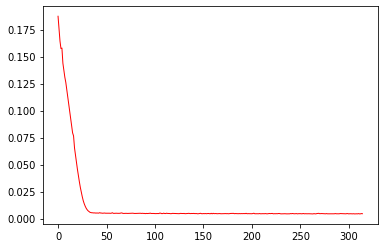

In [ ]:
plt.plot(list_x, list_y, color='r', linewidth=1)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
final_result = np.array(result)
final_true = np.array(true)
plt.plot(final_result, label='prediction')
plt.plot(final_true, label='true')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.title('AAPL Train Set')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
final_result = np.array(result)
final_true = np.array(true)
plt.plot(final_result[:1000], label='prediction')
plt.plot(final_true[:1000], label='true')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.title('AAPL Train Set')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
final_result = np.array(result)
final_true = np.array(true)
plt.plot(final_result[:300], label='pred_output')
plt.plot(final_true[:300], label='test_y')
plt.legend()
plt.grid(True)
plt.title('Test Set')
plt.axis('tight')
plt.show()

In [ ]:
# Test model
model = model.eval()
import gc
gc.collect()
torch.cuda.empty_cache()
result =[]
true =[]
for batch_idx, (test_dl, valid_dl, test_decoder_dl) in enumerate(dl_valid):
    init_states = None
    test_dl, valid_dl, test_decoder_dl = test_dl.to(device), valid_dl.to(device), test_decoder_dl.to(device)
    if MODEL_CHOOSEN == 1:
        pre_output = model((test_dl,test_decoder_dl))
    else:
        pre_ou0tput = model(test_dl)
    loss = loss_function(pre_output, valid_dl)
    # pre_output = pre_output.cpu()
    # pre_output = pre_output.data.numpy()#.reshape(pre_output.shape[1],1)
    valid_dl = valid_dl.cpu()
    valid_dl = valid_dl.data.numpy()
    pre_output = pre_output.cpu()
    pre_output = pre_output.data.numpy()
    for i in pre_output:
        result.append(i)
    for i in valid_dl:
        true.append(i)
    

In [ ]:
loss.item()

In [ ]:
pred = np.array(result)
real = np.array(true)
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(pred, real)#0.00492970272898674
rmse = math.sqrt(mean_squared_error(pred, real))
mae = mean_absolute_error(pred, real)
print('mean_squared_error:%.6f' % mse)
print('root_mean_squared_error:%.6f' % rmse)
print('mean_absolute_error:%.6f' % mae)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(pred, label='pred_output')
plt.plot(real, label='test_y')
plt.legend()
plt.grid(True)
plt.axis('tight')
plt.title('AAPL Test Set')
plt.show()